# Energy A.I. Hackathon 2021 Workflow - ANTICLINE 

#### Authors:  [Esmail Eltahan](https://www.linkedin.com/in/esmaileltahan/), [Jonghyeon Jeon](https://www.linkedin.com/in/jhjeon/), [Mehran Mehrabi](https://www.linkedin.com/in/mehran-mehrabi/), and [Wen Pan](https://www.linkedin.com/in/wen-pan),  
####  Hildebrand Department of Petroleum and Geosystems Engineering, The University of Texas at Austin, Austin, Texas USA 


<img src="https://raw.githubusercontent.com/PGEHackathon/ANTICLINE/main/anticline_official_logo.png?token=ANMA2EZ6IRQ7IZEI5KDH4A3AQTOFC" width=300 />

### Executive Summary 


**1.** In a deep water clastic reservoir, our goal is forecast the cumulative oil production for 10 unproduced wells over the next 3 years using given well log data, reservoir description maps, and production history of the other 73 wells.

**2.** The main challenges in this problem is the small number of samples (73 wells in 10 km by 10 km area), missing values for log reports, and large intra-well and inter-well variability. 

**3.** The strategies we implemented were: (1) Model uncertainty as accurate as we can, (2) Leverage physical insight to find key predictor features that have high relationship with the response feature, (3), Start small, iterate fast, try as many scenarios as possible, and (4) Extensive analysis of the given data and engineered features.

**4.** Key deliverables are: 1) P10, P50, P90 of production forecast for the wells under study, (2) Reliable predictive model for the future wells, (3) Porosity and permeability maps for the area of interest.

**5.** We recommend development at the proposed wells. Our optimistic forecast for their production is 14.5 % larger than the historical average. Our pessimistic estimate is only 5.14 % smaller than the historical average.
___

### Workflow Goal

The ultimate goal of this workflow is to predict the production at 10 well locations. To reach this goal we proceed in main steps listed below. As we proceed in those steps, we also provide insights about the characterization of this reservoir, the statistical correlations, and uncertain geologic models. 
___


### Workflow Steps 

1. **Data Analysis** - problem description, data checking, visualization, analysis
2. **Feature Engineering** - mutual information-based approach with minimum redundancy, introduce new engineering feautures, derive additional properties from the data
3. **Machine Learning** - predict final production using a subset of the available data 
4. **Uncertainty Assessment** - create an uncertainty model that accounts for the error in our prediction 
___

### Deliverables 

1. **Predictive Model** -  Machine-learning based predictive model
2. **Uncertainty Assessment** - Statistical upper and lower bounds on our predictions taking into account model errors  
3. **Aerial Static Models** - 100 realizations of porosity and permeability maps obtained using sequential Gaussian simulation
4. **Emperical Corre
lations** - We report three emperical correlations found in the reservoir: (water cut & depth, production in 1st year & production in following years). The emperical equations are documented as well as verification  

### Import Packages

In [1]:
import numpy as np                                      # model arrays
import pandas as pd                                     # DataFrames
import matplotlib
import matplotlib.pyplot as plt                         # building plots
import os                                               # accessing the operating system
from scipy import spatial                               # Spatial algorithms and data structures
import seaborn as sns                                   # Statistical data visualiztion
from sklearn.decomposition import PCA                   # PCA module
from sklearn.preprocessing import StandardScaler        # standardize features

### Load Data

The following workflow applies the several .csv and .npy files, a synthetic dataset calculated for UT PGE Hackathon competition. You can find the data set [here](https://github.com/PGEHackathon), however, availability is not guaranteed. 




In [2]:
ai = np.load("2d_ai.npy")
sand_propotion = np.load("2d_sand_propotion.npy")
sandy_shale_propotion = np.load("2d_sandy_shale_propotion.npy")
shale_propotion = np.load("2d_shale_propotion.npy")
shaly_sand_propotion = np.load("2d_shaly_sand_propotion.npy")
top_depth = np.load("2d_top_depth.npy")
df_production = pd.read_csv('production_history.csv')
df_production.columns = ['Well_ID','Cumoil1', 'Cumoil2', 'Cumoil3', 'Cumwater1', 'Cumwater2', 'Cumwater3']


## rise of water oil contact. calculated below in volumetric calculations section
woc_rise_1 = np.load("./engineered_maps/woc_rise_1.npy")
woc_rise_2 = np.load("./engineered_maps/woc_rise_2.npy")
woc_rise_3 = np.load("./engineered_maps/woc_rise_3.npy")

# 1. Data Analysis


* Identify key aspects from visuals
* Model porosity and permeability with sequential Gaussian Simulation (SGS)
* Populate missing data

### Reservoir Unit Description

- Size: Clastic deepwater reservoir with extents 10km by 10km by 50m.

- Fluid: Average connate water saturation: 0.203

- Initial: WOC depth: 3067.4 m

- Structure: Anticline with a major fault.

- Fault equation: y = -x + 11750



### Basic Data Checking and Visualization

Since our method relies on the assumption of pairwise correlation, we check the correlation matrix and confirm this. 

* the absolute pariwise correlations exceeds 0.6 for por and logperm, por and AI, AI and TOC etc. 

### Overview of the Fraction of Missing Data

Both the production and preproduction wells have similar distributions. We found that permeability comprises large fraction of the missing data is permeability. Although typical, it raised our concern because permeability is one of the crucial parameters governing fluid flow. However, in order to make full use of the available data, we must impute the missing values. In the same time we account for the uncertainty that arises due to imputation in our uncertainty model.  

![](./images/mm_1.png)

### Overview of the Production and Preproduction Wells
Below we show the variability in the depths at which different wells are sampled/completed, as well as, the cumulative water and oil production of the production wells over three years. 

![](./images/mm_2.png)

### Reservoir Assessment

Upon analyzing the data, Team Anticline believes that the production mechanism is strong water drive. We make this conclusion due to the evidences: 
1. The total production (oil+water) remains almost constant during the first three years, suggesting no decline rate.
2. We modeled the pressure drop (see below in Feature Engineering) caused by production as if the reservoir was under depletion, we found that this pressure drop does not correlate with production decline. 
3. Water cut increases with time, suggesting water coning and rise in water oil contact. This suggests prescence of a strong aquifer.

## Geologic Modeling

We implement 2D Gaussian simulationms in order to build 100 realizations for porosity and permeability for our reservoir. We first construct the spatial 2D experimental variograms for the data samples. 

The following summarizes results from variogram modeling (check `Variogram Modeling.ipynb` for the full implementation). 

#### Summary of Variogram Results



The following code block is from Professor Michael Pyrcz (@GeostatsGuy), Variogram experimental modeling from [GeostatsGuy GitHub] https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/GeostatsPy_variogram_calculation.ipynb 

In [3]:
import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB

#############################################################
### Porosity Variograms
#############################################################
# parameters for shale variogram
nug = 0.0; nst = 1
it1 = 1; cc1 = 1.0; azi1 = 45; hmaj1 = 1400; hmin1 = 1100
por_0_vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1)

# parameters for sandy shale variogram
nug = 0.0; nst = 1
it1 = 1; cc1 = 1.0; azi1 = 90; hmaj1 = 1600; hmin1 = 1000
por_1_vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1)

# parameters for shaly sand variogram
nug = 0.0; nst = 1
it1 = 1; cc1 = 1.0; azi1 = 45; hmaj1 = 1500; hmin1 = 1500
por_2_vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1)

# parameters for sand variogram
nug = 0.0; nst = 1
it1 = 1; cc1 = 1.0; azi1 = 45; hmaj1 = 1600; hmin1 = 1100
por_3_vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1)


#############################################################
### permeability Variograms
#############################################################
# parameters for shale variogram
nug = 0.0; nst = 1
it1 = 1; cc1 = 1.0; azi1 = 0; hmaj1 = 1600; hmin1 = 1300
perm_0_vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1)

# parameters for sandy shale variogram
nug = 0.0; nst = 1
it1 = 1; cc1 = 1.0; azi1 = 0; hmaj1 = 1800; hmin1 = 1400
perm_1_vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1)

# parameters for shaly sand variogram
nug = 0.0; nst = 1
it1 = 1; cc1 = 1.0; azi1 = 0; hmaj1 = 2000; hmin1 = 1000
perm_2_vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1)

# parameters for sand variogram
nug = 0.0; nst = 1
it1 = 1; cc1 = 1.0; azi1 = 90; hmaj1 = 1300; hmin1 = 900
perm_3_vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1)

Here, we show one example for the variogram for permeability for sand facies.
![](./images/image_vario.png)

#### Determine correlation coeeficients

We determine the correlation coefficient between porosity and acoustic impedence, and between permeability and porosity. The correlation coefficients are used as inputs for generating the simulated maps. 

#### Sequential Gaussian Simulation 

The idea is to create 2D areal maps from available sample points. We take the average of proporties for each facies at the well locations, and build sequential gaussian simulation maps per facies. Then we use the facies proportions as weights to get an average map for the properties. The full implementation of the code is available in `Porosity and Permeability Mapping`. 

![](./images/image_sgg_chart.png)

Here is an example realization of the output for permeability for the four facies
![](./images/image_sgs_perm.png)

And here is one realization for the resulting averaged porosity and permeability maps
![](./images/image_sgs_pp.png)



### Thorough Visual Analysis of Production Data Helped Feature Extraction 

#### Summary
Based on some observations from the data (explained in detail later) we built a model to forcast cumulative production of each year from the previous one. Although we can use the production data only from the 1st year to build different models for the 2nd and 3rd year, we found that to build a model for each year leveraging the data from the previous year is more accurate due to less propagation of error due to model uncertainty; also, this will also allow us to take advantage of the availabe data of the 2nd year.

#### Data Trend and Observation

Let Aw, Ao be the cumulative water and oil production over the first year, respectively. Similarly, let Bw, Bo, Cw, and Co be the cumulative water and oil production over the second and third year, respectively. Also, let Awo, Bwo, and Cwo denote, Aw/Ao, Bw/Bo, and Cw/Co respectively. After a thorough analysis of the history of the production data, we made the following observations:

* The total production of all the wells over the 1st, 2nd and 3rd year are constant, i.e. A = Aw+Ao B = Bw+Bo, C = Cw+Co; A == B == C.

* The ratio of the cumulative produced water over the cumulative produced oil can be scaled for almost all the wells over different time intervals.  In other words, for almost all the wells:

    * Bw/Bo is proportional to Aw/Ao with the factor of approximately m=2.7
    * Cw/Co is proportional to Bw/Bo with the factor of approximately n=1.7
    
Based on the above observations, we developed two simple one-parameter models that gives reasonable accuracy for almost all the wells. The models are presented in the next section.

#### Mathematical Models for Production Data


$B_w = \frac{m A_{wo}}{1+m A_{wo}}A$, and $B_o = \frac{1}{1+m A_{wo}}A$, where $m$ is the proportionality factor obtained from the data, $B_{wo}\approx m A_{wo}$, and is approximately $2.7$.

Similarly, $C_w = \frac{n B_{wo}}{1+n B_{wo}}B$, and $C_o = \frac{1}{1+m C_{wo}}B$, where $n$ is the proportionality factor obtained from the data, $C_{wo}\approx n B_{wo}$, and is approximately $1.7$.

![](./images/mm_3.png)



#### Conclusion from Visual Analysis of Production Data
Thorough visual analysis of production data helped us to find a simple relationship between the water/oil ration of the first, second, and third year for all the wells. We quickly found the parameters manually to test our hypothesis and it worked. We later use linear regression to estimate both parameters (i.e. $m$ and $n$) accurately.

![](./images/mm_4.png)

### Overview of the Distribution of One Realization of Various Spatial Maps


![](./images/mm_5.png)

### Box-averaging 

![](./images/mm_6.png)

# 2. Feature Engineering


* Implement domain knowledge
* Isolate the 'big hitters'
* Measure impact on respone

## Calculate properties

Here we calculate some properties from the dataset that might (or might not) turn useful. In the following code, we define the following properties at the well locations:

- `Log_perm`: natural logarithm of permeability
- `mindist`: distance to the nearest well
- `log_mindist`: Natural logarithm of distance to the nearest well
- `avg_inv_dist`: sum of inverse distance to neighbouring wells
- `avg_sq_inv_dist`: sum of square inverse distance to neighbouring wells
- `avg_sqrt_inv_dist`: sum of the square root of  inverse distance to neighbouring wells
- `Top_depth`: depth to the top of formation
- `distance to woc`: distance from depth to OWOC
- `location`: whether above or below the fault line
- `distance to fault`: distance to fault
- `fault indicator`: defines proximity to the fault, takes 1 if `distance to fault > 500`, and takes 0 if otherwise
- `Avg_perm`: average permeability from well log measurements over thickness of well
- `thickness`: thickness of sampled interval
- `bottom to woc`: distance from bottom depth of well to water oil contact 
- `sand prp.`: sand samples per all measurements at well location
- `sandshaly prp.`: sum of sand and shaly sand divided by all measurements at well location
- `k/log_mindist`: permeability divided by log of the distance to the nearest well
- `area_poly`: area of Vornori diagram region around well as a proxy for the drainage area 

We derive the following properties from the production data
- `total1`: total production during the first year
- `total2`: total production during the second year 
- `total3`: total production during the third year
- `prod_o1`: oil production during the first year
- `prod_o2`: oil production during the second year 
- `prod_o3`: oil production during the third year
- `prod_w1`: water production during the first year
- `prod_w2`: water production during the second year
- `prod_w3`: water production during the third year 
- `oil12`: change in oil production from year 1 to year 2
- `oil23`: change in oil production from year 2 to year 3
- `water12`: change in water production from year 1 to year 2
- `water23`: change in water production from year 1 to year 2
- `wcut1`: water cut during the first year
- `wcut2`: water cut during the second year
- `wcut3`: water cut during the third year
- `wcutincrease1`: water cut increase from 1st to 2nd year
- `wcutincrease2`: water cut increase from 2nd to 3rd year


In [4]:
def derive_static_prop(df, avg=True):
    woc = 3067.4
    distance_to_woc = woc - top_depth

    xy1 = np.array([df['X'].values, df['Y'].values]).T
    kdtree = spatial.cKDTree(xy1)
    size_arr = xy1.shape[0]
    mindist=np.zeros(size_arr)
    avg_inv_dist=np.zeros(size_arr)
    avg_sq_inv_dist=np.zeros(size_arr)
    avg_sqrt_inv_dist=np.zeros(size_arr)
    df['Log_perm'] = np.log(df['Perm'])

    for i in range(size_arr):
        arr_dist = kdtree.query(xy1[i], k=100)[0][np.nonzero(kdtree.query(xy1[i], k=100)[0])]
        mindist[i] = (arr_dist).min()
        avg_inv_dist[i] = np.sum(1/(20*arr_dist))
        avg_sq_inv_dist[i] = np.sum(1/(20*np.power(arr_dist, 2)))
        avg_sqrt_inv_dist[i] = np.sum(1/(20*np.sqrt(arr_dist)))

    df["mindist"] = mindist
    df["avg_inv_dist"] = avg_inv_dist
    df["avg_sq_inv_dist"] = avg_sq_inv_dist
    df["avg_sqrt_inv_dist"] = avg_sqrt_inv_dist
    df["log_mindist"] = np.log(mindist)
    df["Top_depth"] = top_depth[df['X'].astype('int')//50, df['Y'].astype('int')//50]
    df["interval"] = df.groupby("Well_ID")["Depth"].diff(1)
    df.loc[np.isnan(df["interval"]),"interval"] = df["Depth"] - df["Top_depth"]
    df["distance to woc"] =  woc - df["Depth"]
    unique_list = df["Well_ID"].unique()
    df.loc[df['Y'] >= (-df['X'] + 11750), "location"] = "below fault line"
    df.loc[df['Y'] < (-df['X'] + 11750), "location"] = "above fault line"
    x0y0=np.array([0,11750])
    dxdy=df[['X', 'Y']] .values-x0y0
    dist=((dxdy[:,0]+dxdy[:,1])/np.sqrt(2)).astype(float)
    df['distance to fault'] = dist
    df['fault indicator'] = (dist < 500)*1
    for well in unique_list:
        df.loc[df["Well_ID"] == well, "Avg_perm"] =(df.loc[(df["Well_ID"] == well) & (~ (np.isnan(df["Perm"]))), "Perm"]).mean()
        df.loc[df["Well_ID"] == well, "thickness"] = df.loc[df["Well_ID"] == well, "Depth"].max() - df.loc[df["Well_ID"] == well, "Depth"].min()
        df.loc[df["Well_ID"] == well, "bottom to woc"] =  woc - df.loc[df["Well_ID"] == well, "Depth"].max() 
        df.loc[df["Well_ID"] == well, "sand prp."] = df.loc[(df["Well_ID"] == well) & (df["Facies"] == "Sandstone")].shape[0]\
        /df.loc[(df["Well_ID"] == well)].shape[0]
        df.loc[df["Well_ID"] == well, "sandshaly prp."] = \
        df.loc[(df["Well_ID"] == well) & ((df["Facies"] == "Sandstone")|(df["Facies"] == "Shaly sandstone")) ].shape[0]\
        /df.loc[(df["Well_ID"] == well)].shape[0]
    df["k/log_mindist"] = df["Avg_perm"] / df["log_mindist"]
    if avg:
        # return the average properties
        df.loc[df['Y'] >= (-df['X'] + 11750), "location"] = 0
        df.loc[df['Y'] < (-df['X'] + 11750), "location"] = 1
        df = df.groupby(["Well_ID"], sort=False, as_index=False).mean()

    return df
 

## Merge static properties with production

Next, we take an extra step to merge the two dataframes we have for the producing wells `df_p` and their corresponding production data `df_production`. 

In [5]:
def merge(df, df_production):
    df_production['total1'] = df_production['Cumwater1'] + df_production['Cumoil1']
    df_production['total2'] = df_production['Cumwater2'] + df_production['Cumoil2']
    df_production['total3'] = df_production['Cumwater3'] + df_production['Cumoil3']  

    df_production['prod_o1'] = df_production['Cumoil1']
    df_production['prod_o2'] = df_production['Cumoil2'] - df_production['Cumoil1']
    df_production['prod_o3'] = df_production['Cumoil3'] - df_production['Cumoil2']

    df_production['prod_w1'] = df_production['Cumwater1']
    df_production['prod_w2'] = df_production['Cumwater2'] - df_production['Cumwater1']
    df_production['prod_w3'] = df_production['Cumwater3'] - df_production['Cumwater2']

    df_production['oil12'] = (df_production['prod_o2']- df_production['prod_o1'])/ df_production['prod_o1']
    df_production['oil23'] = (df_production['prod_o3']- df_production['prod_o2'])/ df_production['prod_o2']

    df_production['water12'] = (df_production['prod_w2']- df_production['prod_w1'])/ df_production['prod_w1']
    df_production['water23'] = (df_production['prod_w3']- df_production['prod_w2'])/ df_production['prod_w2']


    df_production['wcut1'] = df_production['Cumwater1'] / (df_production['Cumoil1'] + df_production['Cumwater1'])
    df_production['wcut2'] = (df_production['Cumwater2'] - df_production['Cumwater1']) / (df_production['Cumoil2'] - df_production['Cumoil1'] + df_production['Cumwater2'] - df_production['Cumwater1'])
    df_production['wcut3'] = (df_production['Cumwater3'] - df_production['Cumwater2'])/ (df_production['Cumoil3'] - df_production['Cumoil2'] + df_production['Cumwater3'] - df_production['Cumwater2'])

    df_production['wcutincrease1'] = (df_production['wcut2']- df_production['wcut1'])/ (df_production['wcut1'])
    df_production['wcutincrease2'] = (df_production['wcut3']- df_production['wcut2']) / (df_production['wcut2'])
    
    df_producers_average = df.groupby(["Well_ID"], sort=False, as_index=False).mean()
    df_producers_average.reset_index(drop=True, inplace=True)
    df_production.reset_index(drop=True, inplace=True)
    df_merged = pd.concat([df, df_production.iloc[:,1:]], axis=1)
    
    return df_merged

## Estimate Pseudo drainage areas based on Voronoi diagram

One of the features we explored in our implementation is the drainage area around well. We construct Voronoi diagram on the wells of interest. From the diagram, we obtain the areas for the Voronoi regions and assign it to each well as a proxy for its drainage area. The resulting areas are saved in column `area_poly`.  

In [6]:
def calculate_voronoi_areas(df, plot=False):
    
    from scipy.spatial import Voronoi, voronoi_plot_2d
    
    points = np.stack([df["X"], df["Y"]]).T
    vor = Voronoi(points)
    if plot:
        fig = voronoi_plot_2d(vor)
        plt.gca().invert_yaxis()
        plt.xlabel("X, m")
        plt.ylabel("Y, m")
        plt.show()
        
    def PolyArea(x,y):
        return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
    
    regions = vor.regions
    vertices = vor.vertices
    Areas = []
    point_region = vor.point_region
    for i in range(points.shape[0]):
        region = regions[point_region[i]]
        Areas.append(PolyArea(vertices[region,0], vertices[region, 1])/1000)
    Areas = np.array(Areas)
    max_area = Areas.max()
    np.count_nonzero(Areas== 0)
    Areas[np.where(Areas>=2000)] = 2000
    df['area_poly'] = Areas
    
    return df

![](image_vironi.png)

## Estimate pressure drop

Below we define two functions to calculate estimates for the pressure drop. The first one `compute_dp_map` computes the pressure drop all over the grid. The second one `compute_dp_map` computes the pressure drop at an individual well location. The pessure drop at any location is the superposition of the drop caused by adjacent wells. i.e., 

$$ \Delta P = \sum_{i}^{N} \Delta P_i$$
where, 
$$ \Delta P_i = \frac{-70.6qB\mu}{kh} Ei \left(\frac{-984 \phi \mu c_t r_i ^2}{kt}\right) $$

for all wells $i\in[N]$. $r_i$ is the Euclidean distance between a contributing well $i$ and the point of interest. 

Similarly, the pressure drop at a  well location can be estimated in a similar manner and adding a term that accounts for the drop due to its own depletion: 
$$ \Delta P_A = \Delta P_A + \sum_{i}^{N} \Delta P_i$$
where, 

$$ \Delta P_A = \frac{-70.6qB\mu}{kh} \ln \left(\frac{-1688 \phi \mu c_t r_w ^2}{kt}\right) $$
$$ \Delta P_i = \frac{-70.6q_iB\mu}{kh} Ei \left(\frac{-984 \phi \mu c_t r_{i-A} ^2}{kt}\right) $$

In [7]:
from scipy.spatial.distance import cdist
from scipy.special import expi

def compute_dp_map(grid, wells, poros, perms, prods_oil, prods_water, t):
    beta_o = 1.5
    beta_w = 1.05
    mu_o = 20.
    mu_w = 1
    h = 10 * 3.28084
    c_t = 1e-6
    distances = cdist(grid, wells)
    distances[np.where(distances< 10)] = 10
    n = grid.shape[0]
    delta_p = np.zeros(n)
    
    delta_p += np.sum(-70.6 * prods_oil *beta_o * mu_o / (perms * h) * expi(-984 * 10.7639 * poros * mu_o * c_t * distances **2 / (perms * t)), axis =1)
    delta_p += np.sum(-70.6 * prods_water *beta_w * mu_w / (perms * h) * expi(-984 * 10.7639 * poros * mu_w * c_t * distances **2 / (perms * t)), axis =1)

    return delta_p

def compute_dp_well(well, wells,por, poros, perm,  perms, prod_oil, prods_oil, prod_water, prods_water, t):
    rw = 0.2
    beta_o = 1.5
    beta_w = 1.05
    mu_o = 20.
    mu_w = 1
    h = 10 * 3.28084
    c_t = 1e-6
    distances = cdist(well, wells)

    delta_p = -70.6 * prod_oil *beta_o * mu_o / (perm * h) * np.log(1688 * mu_o *por *c_t * rw **2 / (perm * t))
    delta_p += -70.6 * prod_water *beta_w * mu_w / (perm * h) * np.log(1688 * mu_w *por *c_t * rw **2 / (perm * t))

    for i in range(len(wells)):
        delta_p += -70.6 * prods_oil[i] *beta_o * mu_o / (perms[i] * h) * expi(-984 * 10.7639 * poros[i] * mu_o * c_t * distances.T[i] **2 / (perms[i] * t))
        delta_p += -70.6 * prods_water[i] *beta_w * mu_w / (perms[i] * h) * expi(-984 * 10.7639 * poros[i] * mu_w * c_t * distances.T[i] **2 / (perms[i] * t))
    return delta_p



In [8]:
def calculate_dp_df(df):
    from scipy.spatial.distance import cdist
    x = np.linspace(25,10000 -25, 200)
    y = x
    X, Y = np.meshgrid(x, y, indexing='ij' )
    xy = np.array([df['X'].values, df['Y'].values]).T
    prods_oil1 = df['Cumoil1'].values
    prods_oil2 = df['Cumoil2'].values - df['Cumoil1'].values
    prods_oil3 = df['Cumoil3'].values - df['Cumoil2'].values

    prods_water1 = df['Cumwater1'].values
    prods_water2 = df['Cumwater2'].values - df['Cumwater1'].values
    prods_water3 = df['Cumwater3'].values - df['Cumwater2'].values

    poros = df['Porosity'].values
    perms = df['Avg_perm'].values

    positions = np.array((X,Y)).T

    positions=positions.reshape([40000, 2])


    distances = cdist(positions, xy)
    distances.shape
    n = positions.shape[0]
    delta_p = np.zeros(n)


    avg_por = 0.128
    avg_perm = 80.


    dp_1 = compute_dp_map(positions, xy, avg_por, avg_perm, prods_oil1/365, prods_water1/365,1*365*24)
    dp_2 = compute_dp_map(positions, xy, avg_por, avg_perm, prods_oil2/365, prods_water2/365, 1*365*24) + dp_1
    dp_3 = compute_dp_map(positions, xy, avg_por, avg_perm, prods_oil3/365, prods_water3/365, 1*365*24) + dp_2

    dp_1 = dp_1.reshape([200,200])
    dp_2 = dp_2.reshape([200,200])
    dp_3 = dp_3.reshape([200,200])


    np.save("./engineered_maps/dp_1", dp_1)
    np.save("./engineered_maps/dp_2", dp_2)
    np.save("./engineered_maps/dp_3", dp_3)


    for well in df["Well_ID"].unique():
            well_coords = np.array([df.loc[df["Well_ID"] == well, "X"].values, df.loc[df["Well_ID"] == well, "Y"].values]).T
            wells_coords = np.array([df.loc[df["Well_ID"] != well, "X"].values, df.loc[df["Well_ID"] != well, "Y"].values]).T

            prod_oil_1 = df.loc[df["Well_ID"] == well, "Cumoil1"].values
            prod_oil_2 = df.loc[df["Well_ID"] == well, "Cumoil2"].values - prod_oil_1
            prod_oil_3 = df.loc[df["Well_ID"] == well, "Cumoil3"].values - prod_oil_2

            prod_water_1 = df.loc[df["Well_ID"] == well, "Cumwater1"].values
            prod_water_2 = df.loc[df["Well_ID"] == well, "Cumwater1"].values - prod_water_1
            prod_water_3 = df.loc[df["Well_ID"] == well, "Cumwater1"].values - prod_water_2

            prods_oil_1 = df.loc[df["Well_ID"] != well, "Cumoil1"].values
            prods_oil_2 = df.loc[df["Well_ID"] != well, "Cumoil2"].values - prods_oil_1
            prods_oil_3 = df.loc[df["Well_ID"] != well, "Cumoil3"].values - prods_oil_2

            prods_water_1 = df.loc[df["Well_ID"] != well, "Cumwater1"].values
            prods_water_2 = df.loc[df["Well_ID"] != well, "Cumwater1"].values - prods_water_1
            prods_water_3 = df.loc[df["Well_ID"] != well, "Cumwater1"].values - prods_water_2

            por = df.loc[df["Well_ID"] == well, "Porosity"].values
            perm = df.loc[df["Well_ID"] == well, "Avg_perm"].values
            poros = df.loc[df["Well_ID"] != well, "Porosity"].values
            perms = df.loc[df["Well_ID"] != well, "Avg_perm"].values

            avg_perms = np.ones_like(perms) * avg_perm
            avg_pors = np.ones_like(poros) * avg_por

            df.loc[df["Well_ID"] == well, "dp_1"] = compute_dp_well(well_coords, wells_coords, avg_por, avg_pors, avg_perm, avg_perms, prod_oil_1/365,prods_oil_1/365, prod_water_1/365,prods_water_1/365,1*365*24)
            df.loc[df["Well_ID"] == well, "dp_2"] = compute_dp_well(well_coords, wells_coords, avg_por, avg_pors, avg_perm, avg_perms, prod_oil_1/365,prods_oil_1/365, prod_water_1/365,prods_water_1/365,1*365*24)
            df.loc[df["Well_ID"] == well, "dp_3"] = compute_dp_well(well_coords, wells_coords, avg_por, avg_pors, avg_perm, avg_perms, prod_oil_1/365,prods_oil_1/365, prod_water_1/365,prods_water_1/365,1*365*24)
    return df

## Estimate WOC rise

Now, we fill in our estimations for the WOC rise at the well locations, depending on the maps we generated in `Volumetric Caclulations.ipynp`. We simply interpolate at the well locations. 

In [9]:
def calculate_woc_rise_df(df):
    df["woc rise 0"] = 0
    df["woc rise 1"] = woc_rise_1[df['X'].astype('int')//50, df['Y'].astype('int')//50] 
    df["woc rise 2"] = woc_rise_2[df['X'].astype('int')//50, df['Y'].astype('int')//50] 
    df["woc rise 3"] = woc_rise_3[df['X'].astype('int')//50, df['Y'].astype('int')//50] 
    df["bottom to woc 1"] = df["bottom to woc"] - woc_rise_1[df['X'].astype('int')//50, df['Y'].astype('int')//50]
    df["bottom to woc 2"] = df["bottom to woc"] - woc_rise_2[df['X'].astype('int')//50, df['Y'].astype('int')//50]
    df["bottom to woc 3"] = df["bottom to woc"] - woc_rise_3[df['X'].astype('int')//50, df['Y'].astype('int')//50]
    return df

In [10]:
N = 1

for i in range(N):
    df_p = pd.read_csv('./imputed_data/df_p_{0:03d}.csv'.format(i))
    df_n = pd.read_csv('./imputed_data/df_n_{0:03d}.csv'.format(i))
    df_p.columns = ['Well_ID','X','Y','Depth','Porosity','Perm','AI', 'Facies', 'Density','Comp_vel','E','Vs','G', 'layer', 'lith_id']
    df_n.columns = ['Well_ID','X','Y','Depth','Porosity','Perm','AI', 'Facies', 'Density','Comp_vel','E','Vs','G', 'layer', 'lith_id']
    df_p = derive_static_prop(df_p)
    df_n = derive_static_prop(df_n)
    df_p = calculate_voronoi_areas(df_p)
    df_n = calculate_voronoi_areas(df_n)
    df_p = calculate_woc_rise_df(df_p)
    df_n = calculate_woc_rise_df(df_n)
    df_merged = merge(df_p, df_production)
    df_merged = calculate_dp_df(df_merged)
    df_n.to_csv('./preprocessed_data/df_n_preprocessed_{0:03d}.csv'.format(i), index=False)
    df_p.to_csv('./preprocessed_data/df_p_preprocessed_{0:03d}.csv'.format(i), index=False)
    df_merged.to_csv('./preprocessed_data/df_merged_{0:03d}.csv'.format(i), index=False)
    

### Volumetric Calculations

In this section, we take advantage of our porosity maps that we generated and make estimates for initial oil in place (IOIP). 


#### First, load the data


In [11]:
train_static_well_dat=pd.read_csv('wellbore_data_preproduction_well.csv')
test_static_well_dat=pd.read_csv('wellbore_data_producer_wells.csv')

#### Load simulated maps

Now we load the already simulated maps per facies that we obtained using sequential Gaussian simulations. The porosity and permeability maps are merged into two large array `por_maps` and `perm_maps`. Each of the arrays has dimension $(L, N, N)$ where $L$ is the number of realizations, $N$ is the number of cells in $x$ and $y$ directions. 

In [12]:
perm_maps = []
por_maps = []
for i in range(N):
    perm_maps.append(np.load("./sgs_maps/perm_{0:03d}.npy".format(i)))
    por_maps.append(np.load("./sgs_maps/por_{0:03d}.npy".format(i)))
por_maps = np.array(por_maps)
perm_maps = np.array(por_maps)

#### Define reservoir properties

Now, we define reservoir properties and make assumtions. Given properies are the water oil contact 
`woc` = 3067.4 m, connate water saturation `Swc` = 20.3%. We have the simulated maps for porosity and the given map for the top depth of the formation. We have all what we need to provide a volumetric estimate for the initial oil in place `IOIP`, except for the formation volume factor `Bo`, which we assume to be = 1.4 STB/RB.

In [13]:
woc = 3067.4
Swc = 20.3/100
dx = 50
dy = 50
Bo = 1.4
N = 100

top_depth=top_depth.reshape([1,200,200])

#### Estimate initial oil in place

We estimate the initial oil in place using the volumetric equation:

$$IOIP = \frac{6.289}{1000 B_o} \int\int\phi(x,y) (WOC - d_{top}(x,y)) (1-S_{wc})\,dx\,dy$$

where the fraction $\frac{6.289}{1000 B_o}$ is to convert the volume from reservoir conditions ($m^3$) to surface conditions (thousand stock tank barrels, MSTB)

In [14]:
IOIPs = np.zeros(N)
#numerical integration
IOIPs = np.sum((1 / Bo) * por_maps * (woc - top_depth) * (1 - Swc) * dx * dy * 6.28981/ 1000, axis =(1,2))  # in MSTB
thickness = woc-top_depth
thickness.mean()
print("Mean IOIP = {:.2f} MSTB".format(IOIPs.mean()))
print("Std. IOIP = {:.2f} MSTB".format(IOIPs.std()))

Mean IOIP = 617205.63 MSTB
Std. IOIP = 0.00 MSTB


#### Estimate recovery factor

We estimate the recovery factor at the end of year 1, 2, and 3. 

$$RF = \frac{G_p}{IOIP}$$

where $G_p$ is the field cumulative oil production. 

In [15]:
Gp_1 = np.sum(df_production['Cumoil1'].values)
Gp_2 = np.sum(df_production['Cumoil2'].values)
Gp_3 = np.sum(df_production['Cumoil3'].values)
IOIP_0 = IOIPs[0]
rf1 = 1 - (IOIPs - Gp_1) / IOIPs
rf2 = 1 - (IOIPs - Gp_2) / IOIPs
rf3 = 1 - (IOIPs - Gp_3) / IOIPs
print("Oil RF 1st year mean = {:.2f} %, std = {:.2f} %".format(rf1.mean()*100, rf1.std()*100))
print("Oil RF 2nd year mean = {:.2f} %, std = {:.2f} %".format(rf2.mean()*100, rf2.std()*100))
print("Oil RF 3rd year mean = {:.2f} %, std = {:.2f} %".format(rf3.mean()*100, rf3.std()*100))

Oil RF 1st year mean = 5.75 %, std = 0.00 %
Oil RF 2nd year mean = 8.91 %, std = 0.00 %
Oil RF 3rd year mean = 11.13 %, std = 0.00 %


#### Estimate rise in WOC

The reservoir under study shows evidence of strong water drive. We believe that the produced oil will be replaced by water from the bottom aquifer. That will cause the water-oil contact (WOC) to rise as the reservoir undergoes depletion. If we assume that no expansion of water, nor expansion of oil, we can write a mass balance in order to determine the the rise of WOC every year, on average, assuming uniform rise accross the reservoir

$$\Delta h_w  = \frac{\frac{1000}{6.289} G_p\times B_o}{\,\int\int\phi(x,y)(1-S_{wc})\,dx\,dy}$$

where $G_p$ is the field cumulative oil production. 

In [16]:
delta_h1 =  Gp_1 * 1000 / np.sum((1 / Bo) * por_maps * (1 - Swc) * dx * dy * 6.28981, axis =(1,2)) 
delta_h2 =  Gp_2 * 1000 / np.sum((1 / Bo) * por_maps * (1 - Swc) * dx * dy * 6.28981, axis =(1,2)) 
delta_h3 =  Gp_3 * 1000 / np.sum((1 / Bo) * por_maps * (1 - Swc) * dx * dy * 6.28981, axis =(1,2)) 
print("Average Rise in WOC 1st year = {:.3f} m, std = {:.3f} m".format(delta_h1.mean(), delta_h1.std()))
print("Average Rise in WOC 2nd year = {:.3f} m, std = {:.3f} m".format(delta_h2.mean(), delta_h2.std()))
print("Average Rise in WOC 3rd year = {:.3f} m, std = {:.3f} m".format(delta_h3.mean(), delta_h3.std()))
print("Average thickness of reservoir = {:.3f} m".format(thickness.mean()))

Average Rise in WOC 1st year = 0.842 m, std = 0.000 m
Average Rise in WOC 2nd year = 1.306 m, std = 0.000 m
Average Rise in WOC 3rd year = 1.631 m, std = 0.000 m
Average thickness of reservoir = 14.492 m


We can do a better job than assuming the rise is uniform accross the reservoir. The rise in WOC should be higher at regions of high oil production, (or equivalently high depletion). We could scale the values we get by the pressure maps we previously obtained. Those pressure maps are directly correlated to the total field production from adjacent wells, and hence it could be used as indicator for the rise in WOC also. 

In [17]:
dp_1 = np.load("./engineered_maps/dp_1.npy")
dp_2 = np.load("./engineered_maps/dp_2.npy")
dp_3 = np.load("./engineered_maps/dp_3.npy")

In [18]:
woc_rise_1 = dp_1 * delta_h1.mean() /dp_1.mean() 
woc_rise_2 = dp_2 * delta_h2.mean() /dp_2.mean() 
woc_rise_3 = dp_3 * delta_h3.mean() /dp_3.mean() 

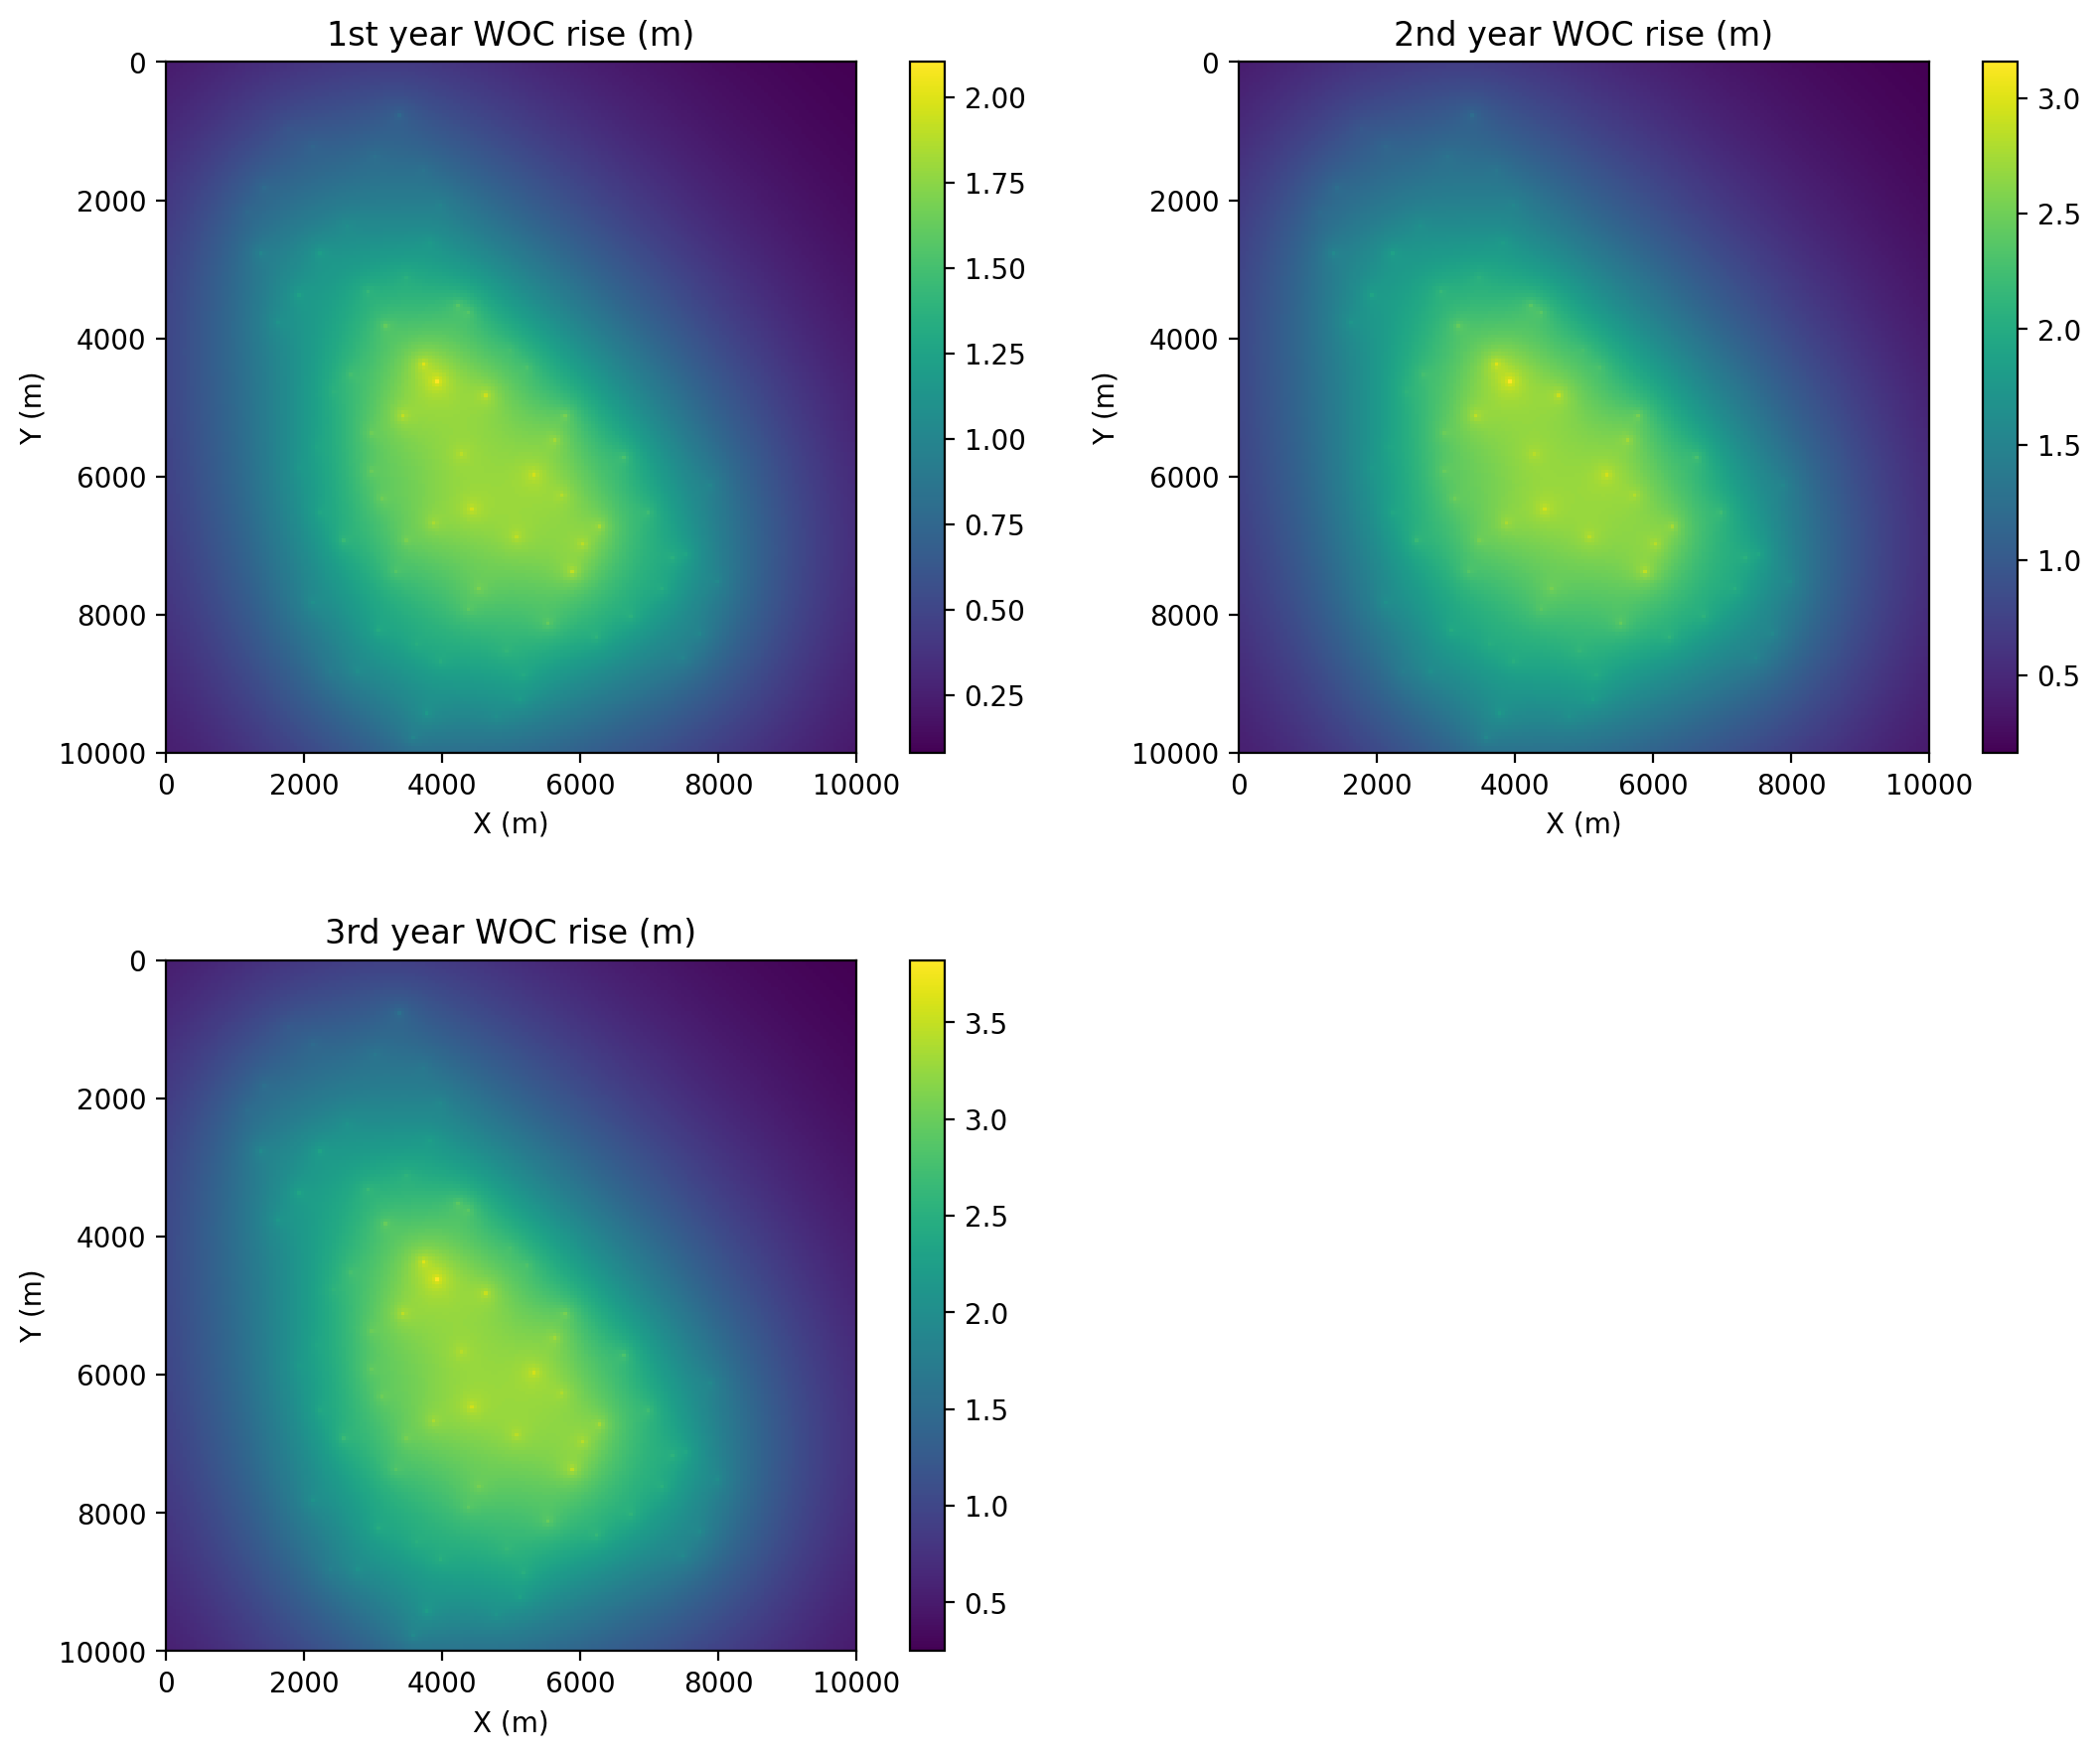

In [19]:
x = np.linspace(0,10000, 50)
y= np.linspace(0,10000, 50)

plt.figure(dpi=200)
plt.subplot(221)
plt.xlim(0,10000)
plt.ylim(0,10000)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("1st year WOC rise (m)")
plt.imshow(woc_rise_1, extent=(x.min(), x.max(), y.max(), y.min()))
plt.colorbar()
plt.gca().invert_yaxis()
plt.subplot(222)
plt.xlim(0,10000)
plt.ylim(0,10000)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("2nd year WOC rise (m)")
plt.imshow(woc_rise_2, extent=(x.min(), x.max(), y.max(), y.min()))
plt.colorbar()
plt.gca().invert_yaxis()
plt.subplot(223)
plt.xlim(0,10000)
plt.ylim(0,10000)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("3rd year WOC rise (m)")
plt.imshow(woc_rise_3, extent=(x.min(), x.max(), y.max(), y.min()))
plt.colorbar()
plt.gca().invert_yaxis()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=2, wspace=0., hspace =0.3)

plt.show()

np.save("./engineered_maps/woc_rise_1",woc_rise_1)
np.save("./engineered_maps/woc_rise_2", woc_rise_2)
np.save("./engineered_maps/woc_rise_3", woc_rise_3)

It is worth noting that we raised this issue to our client. However, we were informed that it is fair to assume that the wells at the new locations will have similar production profile to the wells currently on production. Therefore we did not include these dynamic changes we suspected in our formal analysis. 

## Principle Component Analysis (PCA)
* We transformed given predictor features from predictor feature domain to principle components domain <br>
#### **why?**
* Using our reservoir engineering knowledge, we found out many features on top of given static data set
* However, from the scatter plots, we found that some data is correlated with each other
* To remove the redundancy between features and reduce the dimension of the data, we performed PCA.
* How? PCA converts a set of observations into a set of linearly uncorrelated features
 

First, among the data predictor features from the above data set, we selected 24 features.

In [20]:
var_pca=df_merged.iloc[:,3:28].values                  # Select 24 features out of all predictor features
var_pca_std = StandardScaler().fit_transform(var_pca)  # standardize the data features to mean = 0, var = 1.0

We perform the PCA using 24 principle components and plot a scree plot to check how much variability is explained by each priciple component

Text(0, 0.5, 'explained_variance_ratio')

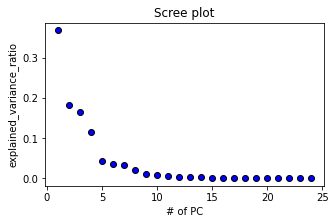

In [21]:
n_components = 24                                   # number of principle components that we are going to use
pca = PCA(n_components=n_components)                # Perform PCA
pca.fit(var_pca_std)
evr={'explained_variance_ratio':np.round(pca.explained_variance_ratio_,3),'# of PC': np.arange(1,25,1)} # Variability explained by each PC
df_evr=pd.DataFrame(data=evr)
f, (ax16) = plt.subplots(1,1,figsize=(5,3))         # Plot the Scree plot
f.subplots_adjust(wspace=0.7)
ax16.scatter(df_evr["# of PC"],df_evr["explained_variance_ratio"],s=None, c="blue", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=1, linewidths=1.0, edgecolors="black")
ax16.set_title('Scree plot'); ax16.set_xlabel('# of PC'); ax16.set_ylabel('explained_variance_ratio')

As a result, first 4 principle components explains 84.6% variability of the data distribution. 
<br> Before we go further, let us check how our data distribution can be changed through simple example.
<br> In this example, we are going to show how the multicollinearity between porosity and permeability is removed using PCA. This example also demonstrates how the data distribution can be changed in principle components domain.

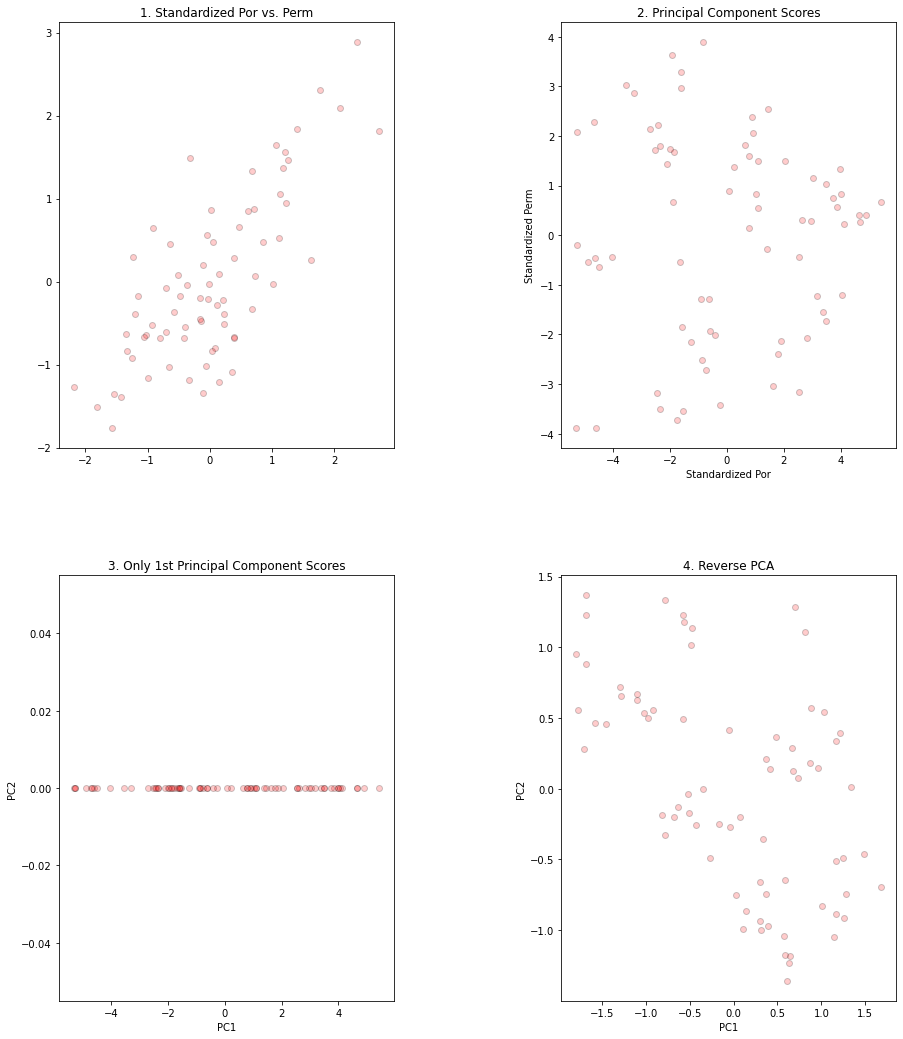

In [22]:
f, ((ax201, ax202), (ax203, ax204)) = plt.subplots(2, 2,figsize=(15,18))
f.subplots_adjust(wspace=0.5,hspace = 0.3)

# Original data distribution when plot on Porosity vs permeability features
ax201.scatter(var_pca_std[:,1],var_pca_std[:,2], s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, edgecolors="black")
ax201.set_title('1. Standardized Por vs. Perm'); ax202.set_xlabel('Standardized Por'); ax202.set_ylabel('Standardized Perm')

# build principal component model with 2 components
n_components = 2                                          
pca = PCA(n_components=n_components)
pca.fit(var_pca_std)
# calculate principal component scores
x_trans = pca.transform(var_pca_std)                                
ax202.scatter(x_trans[:,0],x_trans[:,1],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, edgecolors="black")
ax202.set_title('2. Principal Component Scores'); ax203.set_xlabel('PC1'); ax203.set_ylabel('PC2')

# zero / remove the 2nd principal component to check the amount explained variability using only first PC
temp=x_trans[:,1]*0                                  
ax203.scatter(x_trans[:,0],temp,s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, edgecolors="black")
ax203.set_title('3. Only 1st Principal Component Scores'); ax204.set_xlabel('PC1'); ax204.set_ylabel('PC2')

# reverse the principal component scores to standardized values
xhat = pca.inverse_transform(x_trans)                             
ax204.scatter(xhat[:,0],xhat[:,1],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, edgecolors="black")
ax204.set_title('4. Reverse PCA')

plt.show()

As you can see, in original feature domain, porosity and permeability has strong correlation with each other. It means the redundancy of data set and will have multicollinearity. However, when you see the plot of data distribution in PC1 and PC2 domain, they do not have correlationship, alleviating multicollinearity issue.

<br> Now, we will perform PCA using four principle components. Then, we will use the four feature data set to predict the cumulative oil production of preproduction wells to build a prediction model

# 3. Machine Learning


* Experiment with different methods
* Assess impact on models

### Model #1 

Our first model is built based on our findings of parameters that exhibit very strong relationship, namely:

1. the strong correlation between the WOC to bottom depth and the water cut.
2. our linear relationship we found between the 1st year production and the following years. 
2. the models we experimented with tend to perform more accurately if we train them to predict the first year.

After many iterations, we arrived at the best performing model consists of a sequence of models (or pipeline). We arrive at our final prediction after following three different regressors, each has a specific purpose. We were concerned that this sequential method would give rise to propagation of errors. However, we were surprised that this architecture performed better than all the counterparts. 

![](./images/image_arch.png)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression

In [24]:
def regress_linear(X_variables, y_variable, label, shap=False):
    '''linear regression function'''
    print("Features size: ", X_variables.shape)
    y_trains = []
    y_pred_trains = []
    y_tests = []
    y_pred_tests = []
    np.random.seed(1)
    NN =10
    for i in range(NN):
        X_train, X_test, y_train, y_test = train_test_split(X_variables, y_variable, test_size = 0.3)


        regressor = LinearRegression()

        regressor.fit(X_train, y_train)
        y_pred_test = regressor.predict(X_test)

        y_pred_train = regressor.predict(X_train)
        if i < NN-1:
            del regressor
        y_trains.append(y_train)
        y_pred_trains.append(y_pred_train)
        y_tests.append(y_test)
        y_pred_tests.append(y_pred_test)
    y_trains = np.array(y_trains).flatten()
    y_pred_trains = np.array(y_pred_trains).flatten()
    y_tests = np.array(y_tests).flatten()
    y_pred_tests = np.array(y_pred_tests).flatten()

    print("\nMETRICS FOR TESTING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_tests, y_pred_tests))
    print('Mean Squared Error:', metrics.mean_squared_error(y_tests, y_pred_tests))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_tests, y_pred_tests)))
    print('R-Squared:', metrics.r2_score(y_tests, y_pred_tests))
    print('Explained variance:', metrics.explained_variance_score(y_tests, y_pred_tests))
    print("\nMETRICS FOR TRAINING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_trains, y_pred_trains))
    print('Mean Squared Error:', metrics.mean_squared_error(y_trains, y_pred_trains))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_trains, y_pred_trains)))
    print('R-Squared:', metrics.r2_score(y_trains, y_pred_trains))
    print('Explained variance:', metrics.explained_variance_score(y_trains, y_pred_trains))


    # Training data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=y_trains, y=y_pred_trains, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))  

    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_training.png",
        bbox_inches='tight', dpi=200)
    plt.show()

    plt.close()

    # Testing data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=y_tests, y=y_pred_tests, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))
    
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_testing.png",
        bbox_inches='tight', dpi=150)
    plt.show()
    plt.close()

    if shap:
        #SHAP ###
        import shap
        samples = shap.sample(X_train, 10)
        explainer = shap.KernelExplainer(regressor.predict, samples)

        shap_values = explainer.shap_values(X_train)
        v = plt.figure("shap")
        shap.summary_plot(shap_values, X_train)
        v.savefig("shap_plot1_rf.png", bbox_inches='tight', dpi=150)
        plt.close()
        b = plt.figure("shap_bar")
        shap.summary_plot(shap_values, X_train, plot_type="bar")
        b.savefig("shap_plot_bar_rf.png", bbox_inches='tight', dpi=200)
        plt.close()
    return regressor

Get the third regressor `regressor_13`

Features size:  (73, 2)

METRICS FOR TESTING DATA:

Mean Absolute Error: 35.7649065071929
Mean Squared Error: 2050.2431294571106
Root Mean Squared Error: 45.27961052678248
R-Squared: 0.9873421519604495
Explained variance: 0.9873436160927788

METRICS FOR TRAINING DATA:

Mean Absolute Error: 35.747958937328946
Mean Squared Error: 2058.7474141617176
Root Mean Squared Error: 45.373421891694676
R-Squared: 0.9891817867790302
Explained variance: 0.9891817867790302


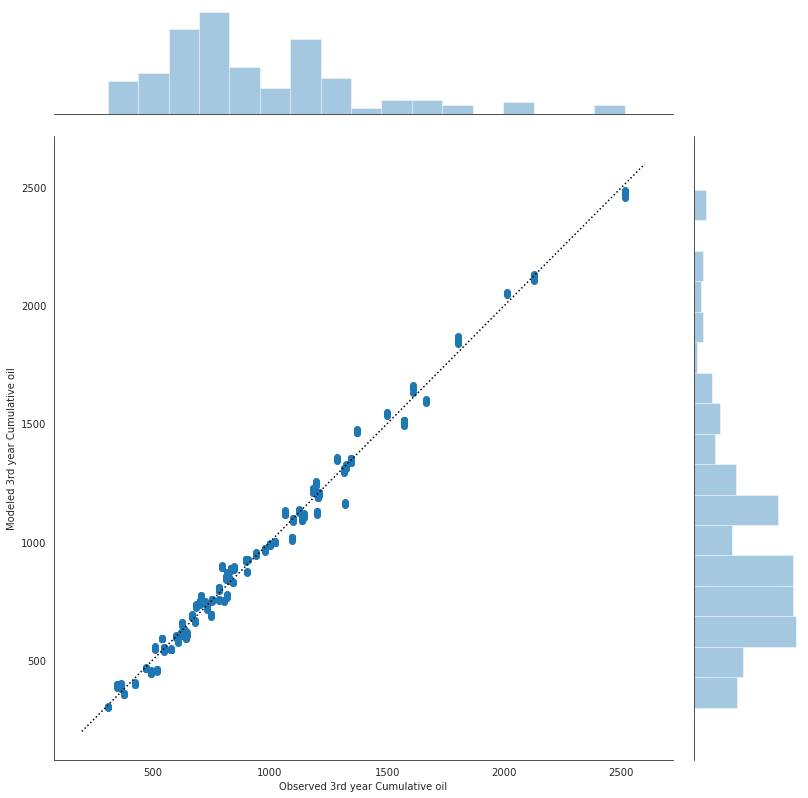

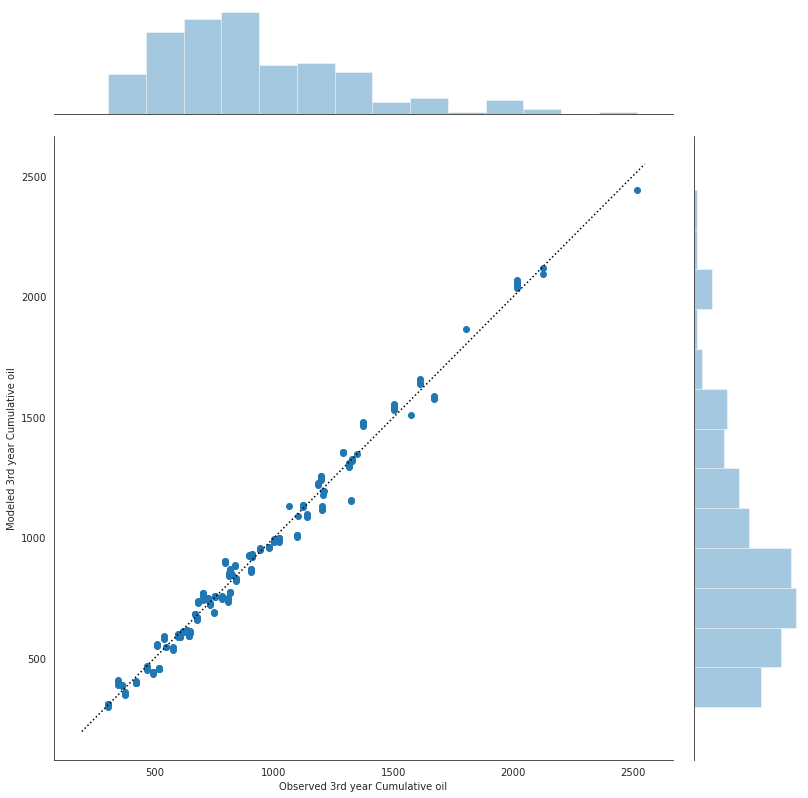

[  1.92876775 158.01587563] -58.90091882716547


In [25]:

X = df_merged[[ "Cumoil1", "wcut1"]]
y = df_merged['Cumoil3']
label = '3rd year Cumulative oil'
regressor_13 = regress_linear(X, y, label)
plt.close()
slope, intercept = regressor_13.coef_ , regressor_13.intercept_ 
print(slope, intercept)

#### Function to calculate 3rd year oil prod

we basically form a pipeline that has a machine learning model that predicts water cut and total and then calculate oil.

In [26]:
def train_cum3(X_total, X_wcut, total, wcut, oil, label, regressor13, method='rf'):

    oil_tests = []
    oil_predict_tests = []
    np.random.seed(1)
    for i in range(10):
        X_total_train, X_total_test, X_wcut_train, X_wcut_test, total_train, total_test, wcut_train, wcut_test, oil_train, oil_test  = \
        train_test_split(X_total, X_wcut, total, wcut, oil , test_size = 0.3)
        if method == 'rf':
            regressor_total = RandomForestRegressor(n_estimators=800, max_depth=25, min_samples_leaf=2,\
                                   min_samples_split= 2, max_features= 'sqrt', bootstrap =False )
        if method == 'linear':
            regressor_total = LinearRegression()
        regressor_total.fit(X_total_train, total_train)
        total_predict_test = regressor_total.predict(X_total_test)
        del regressor_total
        regressor_wcut = LinearRegression()
        regressor_wcut.fit(X_wcut_train, wcut_train)     
        wcut1_predict_test = regressor_wcut.predict(X_wcut_test)
        del regressor_wcut
        oil1_predict_test = total_predict_test*(1-wcut1_predict_test) # 1st year oil
        
        oil_predict_test = regressor13.predict(np.array([oil1_predict_test,wcut1_predict_test]).T) ## 3rd year cum
        
        oil_tests.append(oil_test)
        oil_predict_tests.append(oil_predict_test)        
    
    oil_tests = np.array(oil_tests).flatten()
    oil_predict_tests = np.array(oil_predict_tests).flatten()

    print("\nMETRICS FOR TESTING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(oil_tests, oil_predict_tests))
    print('Mean Squared Error:', metrics.mean_squared_error(oil_tests, oil_predict_tests))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(oil_tests, oil_predict_tests)))
    print('R-Squared:', metrics.r2_score(oil_tests, oil_predict_tests))
    print('Explained variance:', metrics.explained_variance_score(oil_tests, oil_predict_tests))

    

    # Testing data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=oil_tests, y=oil_predict_tests, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))

    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_testing.png",
        bbox_inches='tight', dpi=200)
    plt.show()
    plt.close()
    

#### Validate the model




METRICS FOR TESTING DATA:

Mean Absolute Error: 186.3690557240491
Mean Squared Error: 57276.1030631437
Root Mean Squared Error: 239.32426342338067
R-Squared: 0.7254364999223113
Explained variance: 0.7295376554195748


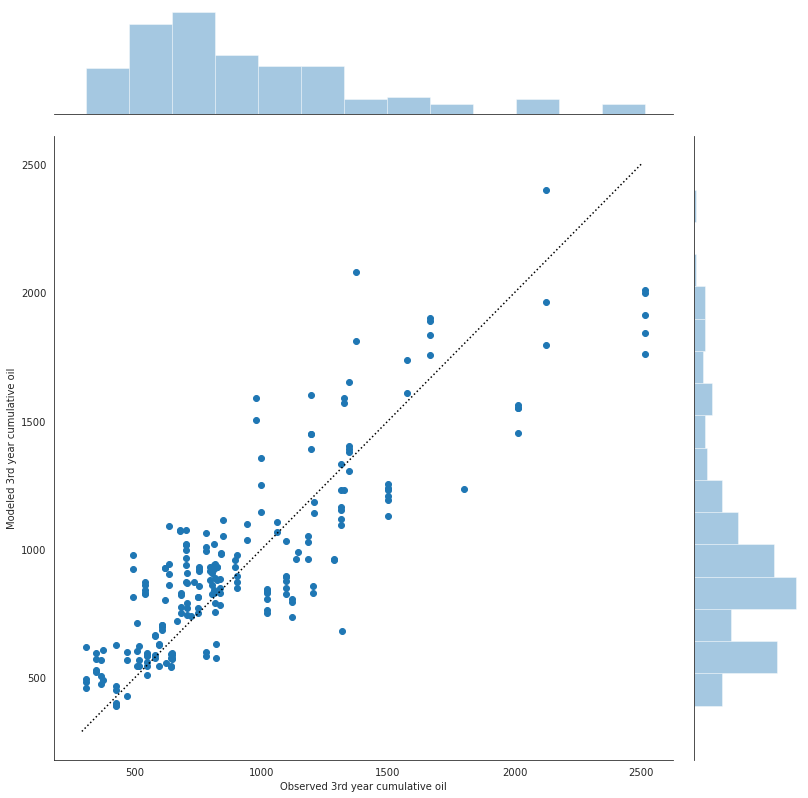

In [27]:
X_wcut = df_merged[['bottom to woc']]
y_wcut = df_merged['wcut1']
X_total = df_merged[[ "Porosity", "Perm", 'sand prp.', 'bottom to woc',  'mindist', 'avg_inv_dist']]
y_total = df_merged['total1']
y_oil = df_merged['Cumoil3']
label = '3rd year cumulative oil'
train_cum3(X_total, X_wcut, y_total, y_wcut, y_oil, label, regressor_13, method='rf')

#### Function to return the final regressors

We define `regree_cum3` to create the regressors based on the above chart, and `predict_cum3_final` to predict on the unknown dataset. 

In [28]:
def regress_cum3(X_total, X_wcut, total, wcut, oil, label, regressor13, method='rf'):
    oil_tests = []
    oil_predict_tests = []
    np.random.seed(4)
    
    X_total_train, X_total_test, X_wcut_train, X_wcut_test, total_train, total_test, wcut_train, wcut_test, oil_train, oil_test  = \
    train_test_split(X_total, X_wcut, total, wcut, oil , test_size = 0.3)
    if method == 'rf':
        regressor_total = RandomForestRegressor(n_estimators=800, max_depth=25, min_samples_leaf=2,\
                               min_samples_split= 2, max_features= 'sqrt', bootstrap =False )
    if method == 'linear':
        regressor_total = LinearRegression()
    regressor_total.fit(X_total_train, total_train)
    total_predict_test = regressor_total.predict(X_total_test)
    regressor_wcut = LinearRegression()
    regressor_wcut.fit(X_wcut_train, wcut_train)     
    wcut1_predict_test = regressor_wcut.predict(X_wcut_test)
    oil1_predict_test = total_predict_test*(1-wcut1_predict_test) # 1st year oil

    oil_predict_test = regressor13.predict(np.array([oil1_predict_test,wcut1_predict_test]).T) ## 3rd year cum

    oil_tests.append(oil_test)
    oil_predict_tests.append(oil_predict_test)
        
    
    oil_tests = np.array(oil_tests).flatten()
    oil_predict_tests = np.array(oil_predict_tests).flatten()
    print(oil_tests.shape)
    print(oil_predict_tests.shape)

    print("\nMETRICS FOR TESTING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(oil_tests, oil_predict_tests))
    print('Mean Squared Error:', metrics.mean_squared_error(oil_tests, oil_predict_tests))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(oil_tests, oil_predict_tests)))
    print('R-Squared:', metrics.r2_score(oil_tests, oil_predict_tests))
    print('Explained variance:', metrics.explained_variance_score(oil_tests, oil_predict_tests))

    # Testing data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=oil_tests, y=oil_predict_tests, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))

    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_testing.png",
        bbox_inches='tight', dpi=200)
    plt.show()
    plt.close()
    return regressor_total, regressor_wcut, regressor13

def predict_cum3_final(X_total, X_wcut,label, regressor_total, regressor_wcut, regressor13, method='rf'):

    total_predict = regressor_total.predict(X_total)
    wcut1_predict = regressor_wcut.predict(X_wcut)
    oil_1_predict = total_predict*(1-wcut1_predict) # 1st year oil
    oil_predict = regressor13.predict(np.array([oil_1_predict,wcut1_predict]).T) ## 3rd year cum        
    

    return oil_predict


(22,)
(22,)

METRICS FOR TESTING DATA:

Mean Absolute Error: 150.82361841310464
Mean Squared Error: 41774.75060400427
Root Mean Squared Error: 204.3887242584685
R-Squared: 0.7292919975416694
Explained variance: 0.7424202157550512


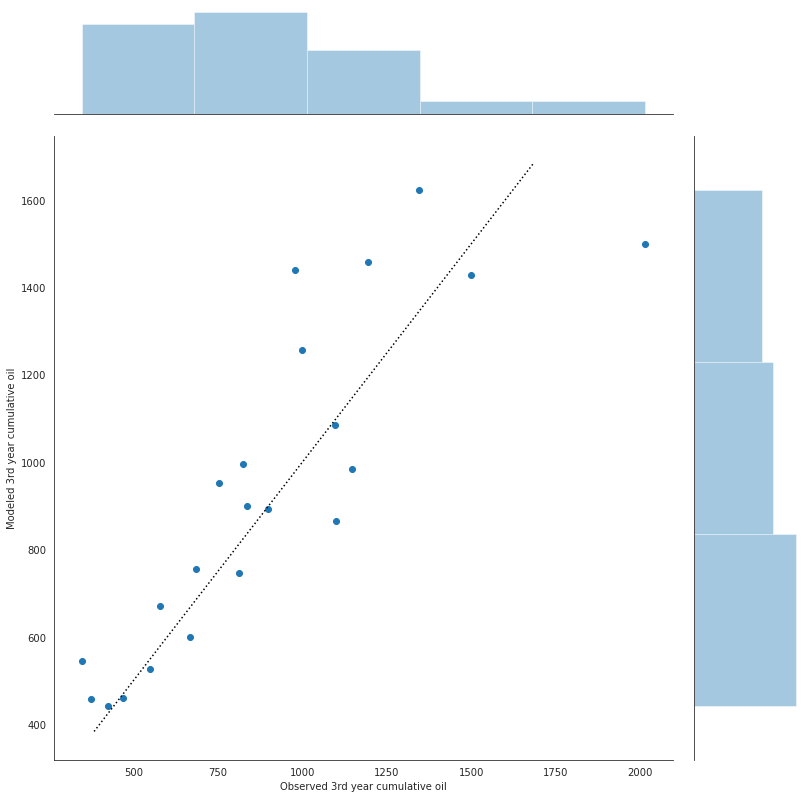

Predictions at the unknown wells:  [1055.12536379  964.3129484  1238.46851454 1555.34859565  976.29920586
 1007.87437844  925.59835023  906.06536946 1299.87122054  884.45345684]


In [29]:
X_wcut = df_merged[['bottom to woc']]
y_wcut = df_merged['wcut1']
X_total = df_merged[[ "Porosity", "Perm", 'sand prp.', 'bottom to woc',  'mindist', 'avg_inv_dist']]
y_total = df_merged['total1']
y_oil = df_merged['Cumoil3']
label = '3rd year cumulative oil'
regressor_total, regressor_wcut, regressor13 = regress_cum3(X_total, X_wcut, y_total, y_wcut, y_oil, label, regressor_13, method='rf')
# new wells predictions
X_wcut = df_n[['bottom to woc']]
X_total = df_n[[ "Porosity", "Perm", 'sand prp.', 'bottom to woc',  'mindist', 'avg_inv_dist']]

predictions = predict_cum3_final(X_total, X_wcut,label, regressor_total, regressor_wcut, regressor13, method='rf')
df_n['Cumoil3'] = predictions
print("Predictions at the unknown wells: ", predictions)

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, ExtraTreesRegressor
from sklearn import metrics

def regress_rf(X_variables, y_variable, label, shap=False):
    print("Features size: ", X_variables.shape)
    y_trains = []
    y_pred_trains = []
    y_tests = []
    y_pred_tests = []
    np.random.seed(1)
    NN =10
    for i in range(NN):
        X_train, X_test, y_train, y_test = train_test_split(X_variables, y_variable, test_size = 0.3)
        

#         print("Training data set size: ",y_train.shape[0])
#         print("Testing data set size: ",y_test.shape[0])

        regressor = RandomForestRegressor(n_estimators=800, max_depth=25, min_samples_leaf=2,\
                                   min_samples_split= 2, max_features= 'sqrt', bootstrap =False )

        regressor.fit(X_train, y_train)
        y_pred_test = regressor.predict(X_test)

        y_pred_train = regressor.predict(X_train)
        if i < NN-1:
            del regressor
        y_trains.append(y_train)
        y_pred_trains.append(y_pred_train)
        y_tests.append(y_test)
        y_pred_tests.append(y_pred_test)
    y_trains = np.array(y_trains).flatten()
    y_pred_trains = np.array(y_pred_trains).flatten()
    y_tests = np.array(y_tests).flatten()
    y_pred_tests = np.array(y_pred_tests).flatten()

    print("\nMETRICS FOR TESTING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_tests, y_pred_tests))
    print('Mean Squared Error:', metrics.mean_squared_error(y_tests, y_pred_tests))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_tests, y_pred_tests)))
    print('R-Squared:', metrics.r2_score(y_tests, y_pred_tests))
    print('Explained variance:', metrics.explained_variance_score(y_tests, y_pred_tests))
    print("\nMETRICS FOR TRAINING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_trains, y_pred_trains))
    print('Mean Squared Error:', metrics.mean_squared_error(y_trains, y_pred_trains))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_trains, y_pred_trains)))
    print('R-Squared:', metrics.r2_score(y_trains, y_pred_trains))
    print('Explained variance:', metrics.explained_variance_score(y_trains, y_pred_trains))

    # Training data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=y_trains, y=y_pred_trains, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))  

    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_training.png",
        bbox_inches='tight', dpi=150)
    plt.show()

    plt.close()

    # Testing data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=y_tests, y=y_pred_tests, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))

    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_testing.png",
        bbox_inches='tight', dpi=150)
    plt.show()
    plt.close()
    
    #SHAP ###
    if shap:
        import shap
        samples = shap.sample(X_train, 10)
        explainer = shap.KernelExplainer(regressor.predict, samples)

        shap_values = explainer.shap_values(X_train)
        v = plt.figure("shap")
        shap.summary_plot(shap_values, X_train)
        v.savefig("shap_plot1_rf.png", bbox_inches='tight', dpi=200)
        plt.close()
        b = plt.figure("shap_bar")
        shap.summary_plot(shap_values, X_train, plot_type="bar")
        b.savefig("shap_plot_bar_rf.png", bbox_inches='tight', dpi=200)
        plt.close()
    return regressor

#### Define one RF regressor

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, ExtraTreesRegressor
from sklearn import metrics

def regress_rf(X_variables, y_variable, label, shap=False):
    print("Features size: ", X_variables.shape)
    y_trains = []
    y_pred_trains = []
    y_tests = []
    y_pred_tests = []
    np.random.seed(1)
    NN =10
    for i in range(NN):
        X_train, X_test, y_train, y_test = train_test_split(X_variables, y_variable, test_size = 0.3)

        regressor = RandomForestRegressor(n_estimators=800, max_depth=25, min_samples_leaf=2,\
                                   min_samples_split= 2, max_features= 'sqrt', bootstrap =False )
        regressor.fit(X_train, y_train)
        y_pred_test = regressor.predict(X_test)

        y_pred_train = regressor.predict(X_train)
        if i < NN-1:
            del regressor
        y_trains.append(y_train)
        y_pred_trains.append(y_pred_train)
        y_tests.append(y_test)
        y_pred_tests.append(y_pred_test)
    y_trains = np.array(y_trains).flatten()
    y_pred_trains = np.array(y_pred_trains).flatten()
    y_tests = np.array(y_tests).flatten()
    y_pred_tests = np.array(y_pred_tests).flatten()

    print("\nMETRICS FOR TESTING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_tests, y_pred_tests))
    print('Mean Squared Error:', metrics.mean_squared_error(y_tests, y_pred_tests))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_tests, y_pred_tests)))
    print('R-Squared:', metrics.r2_score(y_tests, y_pred_tests))
    print('Explained variance:', metrics.explained_variance_score(y_tests, y_pred_tests))
    print("\nMETRICS FOR TRAINING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_trains, y_pred_trains))
    print('Mean Squared Error:', metrics.mean_squared_error(y_trains, y_pred_trains))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_trains, y_pred_trains)))
    print('R-Squared:', metrics.r2_score(y_trains, y_pred_trains))
    print('Explained variance:', metrics.explained_variance_score(y_trains, y_pred_trains))

    # Training data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=y_trains, y=y_pred_trains, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))  

    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_training.png",
        bbox_inches='tight', dpi=150)
    plt.show()

    plt.close()

    # Testing data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=y_tests, y=y_pred_tests, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))

    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_testing.png",
        bbox_inches='tight', dpi=150)
    plt.show()
    plt.close()
    plt.style.use('default')
    
    #SHAP ###
    if shap:
        import shap
        samples = shap.sample(X_train, 10)
        explainer = shap.KernelExplainer(regressor.predict, samples)

        shap_values = explainer.shap_values(X_train)
        v = plt.figure("shap")
        shap.summary_plot(shap_values, X_train)
        v.savefig("shap_plot1_rf.png", bbox_inches='tight', dpi=200)
        plt.close()
        b = plt.figure("shap_bar")
        shap.summary_plot(shap_values, X_train, plot_type="bar")
        b.savefig("shap_plot_bar_rf.png", bbox_inches='tight', dpi=200)
        plt.close()
    return regressor

Features size:  (73, 6)

METRICS FOR TESTING DATA:

Mean Absolute Error: 197.26855113803506
Mean Squared Error: 66074.64356111061
Root Mean Squared Error: 257.0498853551789
R-Squared: 0.592066528380238
Explained variance: 0.5926002168003244

METRICS FOR TRAINING DATA:

Mean Absolute Error: 172.9556454062732
Mean Squared Error: 50824.514104255904
Root Mean Squared Error: 225.44292870759088
R-Squared: 0.732929631556621
Explained variance: 0.7329296315566212


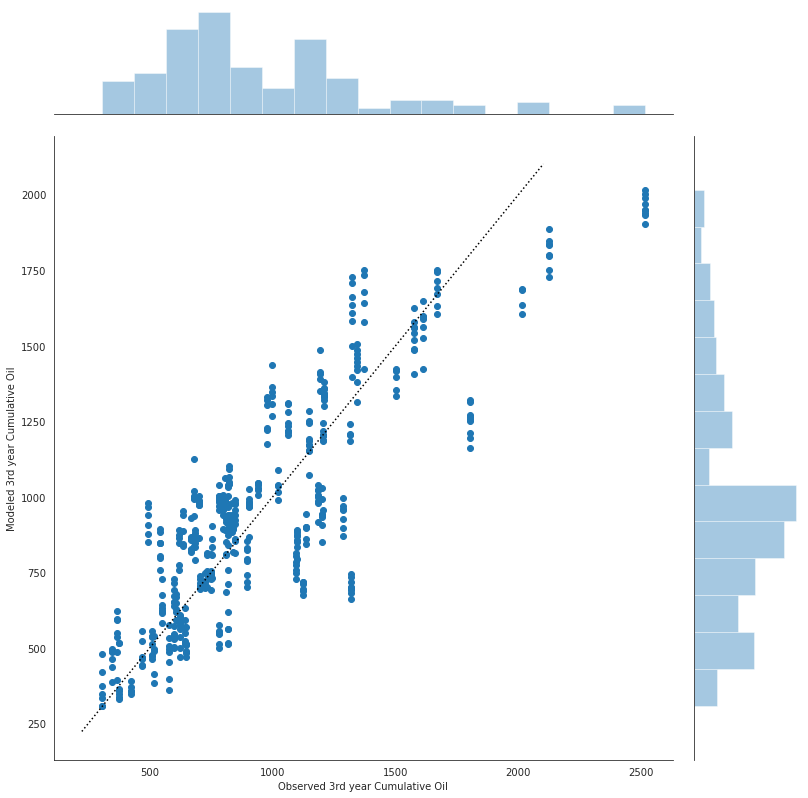

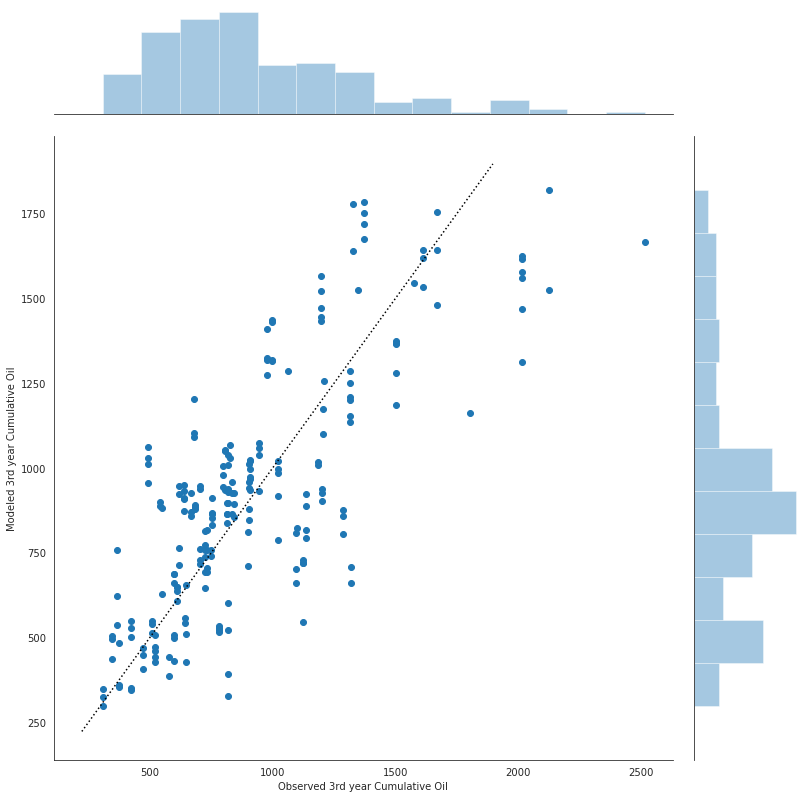

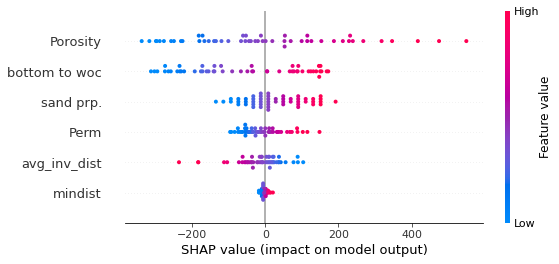

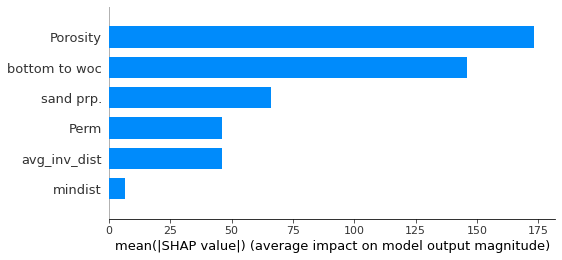

In [32]:
X = df_merged[[ "Porosity", "Perm", 'sand prp.', 'bottom to woc',  'mindist', 'avg_inv_dist']]
y = df_merged['Cumoil3']
label = '3rd year Cumulative Oil'
regressor_wcut = regress_linear(X, y, label, shap=True)

## Multiscale Modeling

The random forest model is built to match production data at well scale, to capture the spatial distribution of well and formation properties, multi-scale CNN is built to calculate regional production, and combined with RF model to improve estimation accuracy and build uncertainty model.
#### Define some utilities

In [33]:
# function for data augmentation
def rot(image, xy, angle):
    im_rot = rotate(image,angle,reshape=True,order=1)
    org_center = (np.array(image.shape[:2][::-1])-1)/2.
    rot_center = (np.array(im_rot.shape[:2][::-1])-1)/2.
    org = xy-org_center
    a = np.deg2rad(angle)
    new = np.array([org[:,0]*np.cos(a) + org[:,1]*np.sin(a),
            -org[:,0]*np.sin(a) + org[:,1]*np.cos(a) ]).T
    return im_rot, np.round(new+rot_center).astype(int)

In [34]:
def get_cnn(patch_size,myfilter=18):
    map_input=layers.Input(shape=(patch_size,patch_size,9))
    map2=layers.Conv2D(myfilter, kernel_size=5, strides=2, padding='same',activation='relu')(map_input)
    map3=layers.Conv2D(myfilter*2, kernel_size=5, strides=2, padding='same',activation='relu')(map2)
    map4=layers.Conv2D(myfilter*2, kernel_size=5, strides=2, padding='same',activation='relu')(map3)
    map5=layers.Flatten()(map4)
    map6=layers.Dense(18,activation='relu')(map5)
    output=layers.Dense(1,activation='sigmoid')(map6)
    model=tf.keras.Model(map_input,output)
    model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(lr=0.0001))
    return model

In [35]:
def get_aug_train_data(window=16,train_iter=10,train_size=10,train_well_cut=1,test_iter=2,test_size=1000,test_well_cut=1,test_area_dim=[10,199,99,199]):
  # well data
  mytrain_patch=[]
  train_target=[]
  mytest_patch=[]
  test_target=[]
  #set 4th feature to 0 to differentiate training and test area  
  map_prop_train=map_prop.copy()
  map_prop_train[test_area_dim[0]:test_area_dim[1],test_area_dim[2]:test_area_dim[3],4]=0
  for ii in range(train_iter):
    map_prop_train_rot,new_xy = rot(map_prop_train,my_well_data[test_id==False][:,:2], np.random.uniform(0,360))
    #add corresponding well data
    map_prop_train_rot[new_xy[:,1],new_xy[:,0],-4:]=my_well_data[test_id==False][:,2:6]#well_loc,poro,perm,prod
    map_prop_train_rot[:,:,6:9]=maximum_filter(map_prop_train_rot[:,:,6:9],size=(5,5,1),mode='nearest')#well_loc,poro,perm
    patches = image.extract_patches_2d(map_prop_train_rot, (window, window),max_patches=int(30*train_size))
    good=((np.sum(patches[:,:,:,4]>0,axis=(1,2))==(patches.shape[1]*patches.shape[2]))*(np.sum(patches[:,:,:,-1]>0,axis=(1,2))>=train_well_cut)).astype(bool)# not padded and more than cut well
    patches=patches[good][:train_size]
    target=np.sum(patches[:,:,:,-1],axis=(1,2))
    
    for i in range(patches.shape[0]):
      if np.random.uniform(0,1)>0.5:
        patches[i]=np.fliplr(patches[i])
      if np.random.uniform(0,1)>0.5:
        patches[i]=np.flipud(patches[i])
        
    mytrain_patch.append(patches.copy())
    train_target.append(target.copy())
    print('train_'+str(ii))
  mytrain_patch=np.concatenate(mytrain_patch)
  train_target=np.concatenate(train_target) 

  #test patches
  xy_test=my_well_data[test_id==True][:,:2].copy()
  xy_test[:,0]=xy_test[:,0]-test_area_dim[2] #move wells to new patch coord
  xy_test[:,1]=xy_test[:,1]-test_area_dim[0]
  for ii in range(test_iter):
    map_prop_train_rot = map_prop[test_area_dim[0]:test_area_dim[1],test_area_dim[2]:test_area_dim[3]].copy()
    new_xy=xy_test.astype(int).copy()
    #add corresponding well data
    map_prop_train_rot[new_xy[:,1],new_xy[:,0],-4:]=my_well_data[test_id==True][:,2:6]#well_loc,poro,perm,prod
    map_prop_train_rot[:,:,6:9]=maximum_filter(map_prop_train_rot[:,:,6:9],size=(5,5,1),mode='nearest')#well_loc,poro,perm

    patches = image.extract_patches_2d(map_prop_train_rot, (window, window),max_patches=5000)
    good=((np.sum(patches[:,:,:,4]>0,axis=(1,2))==(patches.shape[1]*patches.shape[2]))*(np.sum(patches[:,:,:,-1]>0,axis=(1,2))>=test_well_cut)).astype(bool)
    patches=patches[good][:test_size]
    target=np.sum(patches[:,:,:,-1],axis=(1,2))
    mytest_patch.append(patches.copy())
    test_target.append(target.copy())  
    print('test_'+str(ii))
  mytest_patch=np.concatenate(mytest_patch)
  test_target=np.concatenate(test_target)
  return mytrain_patch,train_target,mytest_patch,test_target

In [36]:
def get_test_coef(window_size=64,min_test_well=5,NN=100):#window size, minimum test wells in patch; total patch
  my_patch=[]
  wells=[]

  xy_test=my_well_data[test_id==True][:,:2].astype(int).copy()
  xy_train=my_well_data[test_id==False][:,:2].astype(int).copy()
  xy=my_well_data[:,:2].astype(int).copy()
  map_prop_train_rot= map_prop.copy()
  #add corresponding well data
  map_prop_train_rot[xy[:,1],xy[:,0],-4:]=my_well_data[:,2:6]#well_loc,poro,perm,prod
  map_prop_train_rot[:,:,6:9]=maximum_filter(map_prop_train_rot[:,:,6:9],size=(5,5,1),mode='nearest')#well_loc,poro,perm
  train_well_map=np.zeros((map_prop_train_rot.shape[0],map_prop_train_rot.shape[1],1))
  test_well_map=train_well_map.copy()
  test_well_map_id=-np.ones(train_well_map.shape)

  train_well_map[xy_train[:,1],xy_train[:,0]]=1
  test_well_map[xy_test[:,1],xy_test[:,0]]=1
  test_well_map_id[xy_test[:,1],xy_test[:,0],0]=np.arange(xy_test.shape[0])
  map_prop_add=np.concatenate([map_prop_train_rot,train_well_map,test_well_map,test_well_map_id],axis=-1)

  patches0=[]
  target0=[]

 
  patches = image.extract_patches_2d(map_prop_add, (window_size, window_size),max_patches=int(64000/window_size))
  good=((np.sum(patches[:,:,:,-2],axis=(1,2))>=min_test_well)).astype(bool)#more than 5 test wells in the patch
  patches=patches[good][:NN]

  coefficients=np.zeros((NN,xy_test.shape[0]))
  for i in range(patches.shape[0]):
    coefficients[i][patches[i,:,:,-1][patches[i,:,:,-1]>=0].astype(int)]=1


  test_prod=np.sum(patches[:,:,:,-2]*patches[:,:,:,9],axis=(1,2))#test*prod
  train_prod=np.sum(patches[:,:,:,-3]*patches[:,:,:,9],axis=(1,2))#train*prod
  return test_prod, train_prod,coefficients,patches

In [37]:
def calculate_cum4(X_total, X_wcut, total, wcut, oil, label, regressor13, method='rf',test_label=[1]):
    oil_tests = []
    oil_predict_tests = []
    np.random.seed(1)
    X_total_train=X_total[~test_label]
    X_total_test=X_total[test_label]
    X_wcut_train=X_wcut[~test_label]
    X_wcut_test=X_wcut[test_label]
    total_train=total[~test_label]
    total_test=total[test_label]
    wcut_train=wcut[~test_label]
    wcut_test=wcut[test_label]
    oil_train=wcut[~test_label]
    oil_test=oil[test_label]
    
    
    
    
    
    
    if method == 'rf':
        regressor_total = RandomForestRegressor(n_estimators=800, max_depth=25, min_samples_leaf=2,\
                               min_samples_split= 2, max_features= 'sqrt', bootstrap =False )
    if method == 'linear':
        regressor_total = LinearRegression()
    regressor_total.fit(X_total_train, total_train)
    total_predict_test = regressor_total.predict(X_total_test)
    del regressor_total
    regressor_wcut = LinearRegression()
    regressor_wcut.fit(X_wcut_train, wcut_train)     
    wcut1_predict_test = regressor_wcut.predict(X_wcut_test)
    del regressor_wcut
    oil1_predict_test = total_predict_test*(1-wcut1_predict_test) # 1st year oil

    oil_predict_test = regressor13.predict(np.array([oil1_predict_test,wcut1_predict_test]).T) ## 3rd year cum

    oil_tests.append(oil_test)
    oil_predict_tests.append(oil_predict_test)
#         print(oil_test.shape == oil_predict_test.shape)


    oil_tests = np.array(oil_tests).flatten()
    oil_predict_tests = np.array(oil_predict_tests).flatten()
    return oil_predict_tests
    

### Regional production is calculated with CNN and used to constrain the calculation for the production data of each individual wells



In [38]:
import tensorflow as tf
from tensorflow.keras import layers
from scipy.ndimage import maximum_filter,rotate
from sklearn.feature_extraction import image

In [39]:
ai = np.load("2d_ai.npy")
sand_propotion = np.load("2d_sand_propotion.npy")
sandy_shale_propotion = np.load("2d_sandy_shale_propotion.npy")
shale_propotion = np.load("2d_shale_propotion.npy")
shaly_sand_propotion = np.load("2d_shaly_sand_propotion.npy")
top_depth = np.load("2d_top_depth.npy")

df_production = pd.read_csv('production_history.csv')
df_p = pd.read_csv('./preprocessed_data/df_p_preprocessed_{0:03d}.csv'.format(0))
df_n = pd.read_csv('./preprocessed_data/df_n_preprocessed_{0:03d}.csv'.format(1))
df_merged = pd.read_csv('./preprocessed_data/df_merged_{0:03d}.csv'.format(0))
df_n_merged=pd.read_csv('./preprocessed_data/df_n_preprocessed_{0:03d}.csv'.format(1))
df_merged['ID']=np.arange(df_merged.shape[0])


In [40]:
#production data scaling
prod_scale=(df_merged['Cumoil3'].values.max()*1.3-df_merged['Cumoil3'].values.min()*0.7)
prod_bias=df_merged['Cumoil3'].values.min()*0.7
train_y=df_merged['Cumoil3'].values
train_y=(train_y-prod_bias)/prod_scale

#well location map
well_loc=np.zeros((200,200))
prodmap=well_loc.copy()

X=df_merged['X'].values.astype(float).copy()
Y=df_merged['Y'].values.astype(float).copy()
X=np.round((X-25)/50).astype(int)
Y=np.round((Y-25)/50).astype(int)
XY=np.stack([X,Y],axis=1)

df_merged['ID']=np.arange(73)
wellid=np.arange(73)

poro_mean=df_merged['Porosity']
perm_mean=df_merged['Perm']

poro_mean=(poro_mean-poro_mean.min()+0.1)/(poro_mean.max()-poro_mean.min()+0.1)
perm_mean=(perm_mean-perm_mean.min()+0.5)/(perm_mean.max()-perm_mean.min()+0.5)


#well location map
well_loc=np.zeros((200,200))
perm_map=well_loc.copy()
poro_map=well_loc.copy()
prodmap=well_loc.copy()
well_loc[Y,X]=1
new_prod=train_y.copy()
# well data
test_area_dim=[10,199,99,199]
test_id=((X>test_area_dim[2])*(X<test_area_dim[3])*(Y>test_area_dim[0])*(Y<test_area_dim[1])).astype(bool)
my_well_data=np.stack([X,Y,np.ones(73),poro_mean[:73],perm_mean[:73],new_prod,test_id],axis=-1)
    


# poro and perm map are random realizations
map_prop=np.stack([sand_propotion,sandy_shale_propotion,shaly_sand_propotion,
                   shale_propotion,(top_depth-top_depth.min())/(top_depth.max()-top_depth.min())+0.0001,
                   (ai-ai.min())/(ai.max()-ai.min())+0.0001,well_loc,poro_map,perm_map,prodmap],axis=-1)



In [41]:
# total oil production in patch of size 64 by 64
cnn_model=get_cnn(64)
mytrain_patch,train_target,mytest_patch,test_target=get_aug_train_data(window=64,train_iter=100,train_size=10,train_well_cut=6,test_iter=2,test_size=1000,test_well_cut=6,test_area_dim=[100,199,100,199])
cnn_model.fit(x=mytrain_patch[:,:,:,:-1],y=train_target.reshape([-1,1])/20,validation_data=(mytest_patch[:,:,:,:-1],test_target.reshape([-1,1])/20),batch_size=256,epochs=100)

train_0
train_1
train_2
train_3
train_4
train_5
train_6
train_7
train_8
train_9
train_10
train_11
train_12
train_13
train_14
train_15
train_16
train_17
train_18
train_19
train_20
train_21
train_22
train_23
train_24
train_25
train_26
train_27
train_28
train_29
train_30
train_31
train_32
train_33
train_34
train_35
train_36
train_37
train_38
train_39
train_40
train_41
train_42
train_43
train_44
train_45
train_46
train_47
train_48
train_49
train_50
train_51
train_52
train_53
train_54
train_55
train_56
train_57
train_58
train_59
train_60
train_61
train_62
train_63
train_64
train_65
train_66
train_67
train_68
train_69
train_70
train_71
train_72
train_73
train_74
train_75
train_76
train_77
train_78
train_79
train_80
train_81
train_82
train_83
train_84
train_85
train_86
train_87
train_88
train_89
train_90
train_91
train_92
train_93
train_94
train_95
train_96
train_97
train_98
train_99
test_0
test_1
Epoch 1/100
4/4 [==============================] - 2s 591ms/step - loss: 0.1349 - val_loss: 0.10

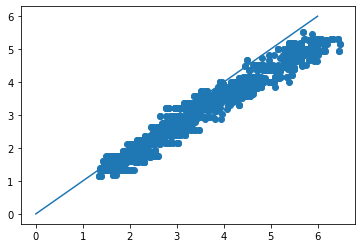

In [42]:
#visualize the match of total production at scale 64 by 64
mypred=cnn_model(mytest_patch[:,:,:,:-1]).numpy()
plt.scatter(mypred.flatten()*20,test_target)
xx=[0,6]
yy=xx
sns.reset_orig()

plt.plot(xx,yy)

In [43]:
# total oil production in patch of size 32 by 32
cnn_model32=get_cnn(32)
mytrain_patch,train_target,mytest_patch,test_target=get_aug_train_data(window=32,train_iter=100,train_size=10,train_well_cut=1,test_iter=2,test_size=1000,test_well_cut=1,test_area_dim=[100,199,100,199])
cnn_model32.fit(x=mytrain_patch[:,:,:,:-1],y=train_target.reshape([-1,1])/4,validation_data=(mytest_patch[:,:,:,:-1],test_target.reshape([-1,1])/4),batch_size=256,epochs=50)

train_0
train_1
train_2
train_3
train_4
train_5
train_6
train_7
train_8
train_9
train_10
train_11
train_12
train_13
train_14
train_15
train_16
train_17
train_18
train_19
train_20
train_21
train_22
train_23
train_24
train_25
train_26
train_27
train_28
train_29
train_30
train_31
train_32
train_33
train_34
train_35
train_36
train_37
train_38
train_39
train_40
train_41
train_42
train_43
train_44
train_45
train_46
train_47
train_48
train_49
train_50
train_51
train_52
train_53
train_54
train_55
train_56
train_57
train_58
train_59
train_60
train_61
train_62
train_63
train_64
train_65
train_66
train_67
train_68
train_69
train_70
train_71
train_72
train_73
train_74
train_75
train_76
train_77
train_78
train_79
train_80
train_81
train_82
train_83
train_84
train_85
train_86
train_87
train_88
train_89
train_90
train_91
train_92
train_93
train_94
train_95
train_96
train_97
train_98
train_99
test_0
test_1
Epoch 1/50
4/4 [==============================] - 1s 211ms/step - loss: 0.1218 - val_loss: 0.089

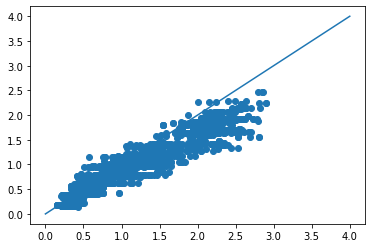

In [44]:
#visualize the match of total production at scale 64 by 64
mypred=cnn_model32(mytest_patch[:,:,:,:-1]).numpy()
plt.scatter(mypred.flatten()*4,test_target)
xx=[0,4]
yy=xx
plt.plot(xx,yy)

In [45]:
# total oil production in patch of size 16 by 16
cnn_model16=get_cnn(16,4)
mytrain_patch,train_target,mytest_patch,test_target=get_aug_train_data(window=16,train_iter=100,train_size=10,train_well_cut=1,test_iter=2,test_size=1000,test_well_cut=1,test_area_dim=[100,199,100,199])
cnn_model16.fit(x=mytrain_patch[:,:,:,:-1],y=train_target.reshape([-1,1])/2,validation_data=(mytest_patch[:,:,:,:-1],test_target.reshape([-1,1])/2),batch_size=256,epochs=300)

train_0
train_1
train_2
train_3
train_4
train_5
train_6
train_7
train_8
train_9
train_10
train_11
train_12
train_13
train_14
train_15
train_16
train_17
train_18
train_19
train_20
train_21
train_22
train_23
train_24
train_25
train_26
train_27
train_28
train_29
train_30
train_31
train_32
train_33
train_34
train_35
train_36
train_37
train_38
train_39
train_40
train_41
train_42
train_43
train_44
train_45
train_46
train_47
train_48
train_49
train_50
train_51
train_52
train_53
train_54
train_55
train_56
train_57
train_58
train_59
train_60
train_61
train_62
train_63
train_64
train_65
train_66
train_67
train_68
train_69
train_70
train_71
train_72
train_73
train_74
train_75
train_76
train_77
train_78
train_79
train_80
train_81
train_82
train_83
train_84
train_85
train_86
train_87
train_88
train_89
train_90
train_91
train_92
train_93
train_94
train_95
train_96
train_97
train_98
train_99
test_0
test_1
Epoch 1/300
4/4 [==============================] - 1s 63ms/step - loss: 0.1429 - val_loss: 0.114

4/4 [==============================] - 0s 33ms/step - loss: 0.0073 - val_loss: 0.0070
Epoch 157/300
4/4 [==============================] - 0s 35ms/step - loss: 0.0064 - val_loss: 0.0070
Epoch 158/300
4/4 [==============================] - 0s 33ms/step - loss: 0.0065 - val_loss: 0.0070
Epoch 159/300
4/4 [==============================] - 0s 33ms/step - loss: 0.0068 - val_loss: 0.0071
Epoch 160/300
4/4 [==============================] - 0s 33ms/step - loss: 0.0063 - val_loss: 0.0067
Epoch 161/300
4/4 [==============================] - 0s 33ms/step - loss: 0.0057 - val_loss: 0.0067
Epoch 162/300
4/4 [==============================] - 0s 33ms/step - loss: 0.0066 - val_loss: 0.0071
Epoch 163/300
4/4 [==============================] - 0s 33ms/step - loss: 0.0064 - val_loss: 0.0069
Epoch 164/300
4/4 [==============================] - 0s 33ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 165/300
4/4 [==============================] - 0s 32ms/step - loss: 0.0061 - val_loss: 0.0067
Epoch 166/300


4/4 [==============================] - 0s 33ms/step - loss: 0.0047 - val_loss: 0.0080
Epoch 239/300
4/4 [==============================] - 0s 33ms/step - loss: 0.0047 - val_loss: 0.0087
Epoch 240/300
4/4 [==============================] - 0s 31ms/step - loss: 0.0047 - val_loss: 0.0079
Epoch 241/300
4/4 [==============================] - 0s 32ms/step - loss: 0.0043 - val_loss: 0.0080
Epoch 242/300
4/4 [==============================] - 0s 33ms/step - loss: 0.0047 - val_loss: 0.0087
Epoch 243/300
4/4 [==============================] - 0s 32ms/step - loss: 0.0044 - val_loss: 0.0082
Epoch 244/300
4/4 [==============================] - 0s 32ms/step - loss: 0.0042 - val_loss: 0.0080
Epoch 245/300
4/4 [==============================] - 0s 32ms/step - loss: 0.0046 - val_loss: 0.0087
Epoch 246/300
4/4 [==============================] - 0s 32ms/step - loss: 0.0043 - val_loss: 0.0081
Epoch 247/300
4/4 [==============================] - 0s 32ms/step - loss: 0.0048 - val_loss: 0.0083
Epoch 248/300


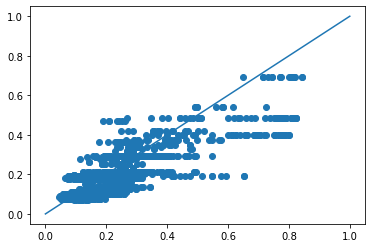

In [46]:
mypred=cnn_model16(mytest_patch[:,:,:,:-1]).numpy()
plt.scatter(mypred.flatten(),test_target/2)
xx=[0,1]
yy=xx
plt.plot(xx,yy)

# 4. Uncertainty Assessment

* Uncertainty includes the propogation of uncertainty from data imputation and random reservoir model realizations, and also the error caused by our selection of machine learning model. 

* We thus run several simulation to capture the uncertainty propagation, and use summary statistics to guide the calculation for the uncertainty associated with model choice

* Standard deviation calculated with validation set is used to generate realizations 

## Linear regression
As patch size decreases the accuracy decreases, total production at large scale is used to constrain the production estimate at fine scale and incorporate influences of adjacent wells

In [47]:
test_prod_64,train_prod_64,coefficients_64,patches_64=get_test_coef(window_size=64,min_test_well=5,NN=100)
cnn_64_pred=cnn_model(patches_64[:,:,:,:9]).numpy()*20
cnn_64_test_prod=cnn_64_pred.flatten()-train_prod_64
cnn_64_test_prod=cnn_64_test_prod*prod_scale+prod_bias

In [48]:
test_prod_32,train_prod_32,coefficients_32,patches_32=get_test_coef(window_size=32,min_test_well=1,NN=100)
cnn_32_pred=cnn_model32(patches_32[:,:,:,:9]).numpy()*4
cnn_32_test_prod=cnn_32_pred.flatten()-train_prod_32
cnn_32_test_prod=cnn_32_test_prod*prod_scale+prod_bias

In [49]:
test_prod_16,train_prod_16,coefficients_16,patches_16=get_test_coef(window_size=16,min_test_well=1,NN=100)
cnn_16_pred=cnn_model16(patches_16[:,:,:,:9]).numpy()*2
cnn_16_test_prod=cnn_16_pred.flatten()-train_prod_16
cnn_16_test_prod=cnn_16_test_prod*prod_scale+prod_bias

In [50]:
X_wcut = df_merged[['bottom to woc']]
y_wcut = df_merged['wcut1']
X_total = df_merged[[ "Porosity", "Perm", 'AI', 'sand prp.', 'bottom to woc',  'mindist', 'avg_inv_dist']]
y_total = df_merged['total1']
y_oil = df_merged['Cumoil3']
label = '3rd year cumulative oil'
single_pred=calculate_cum4(X_total, X_wcut, y_total, y_wcut, y_oil, label, regressor_13, method='rf',test_label=test_id==True)
single_scaled=single_pred

### Randomized maximized likelihood

Randomized maximized likelihood estimates are used to quantify uncertainties, data at different scales are selected based on the variance of validation set.

### MSE at well scale

In [51]:
multipliers=[1,8,16,32]

bb=np.concatenate([multipliers[0]*cnn_64_test_prod,multipliers[1]*cnn_32_test_prod,
                   multipliers[2]*cnn_16_test_prod,multipliers[3]*single_pred])
A=np.concatenate([multipliers[0]*coefficients_64,multipliers[1]*coefficients_32,
                  multipliers[2]*coefficients_16,multipliers[3]*np.eye(int(np.sum(test_id)))],axis=0)
solution,resid,rank,s=np.linalg.lstsq(A,bb)

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [52]:
print('Posterior mean:'+ str(metrics.mean_squared_error(solution,y_oil[test_id])))

Posterior mean:60455.36349899878


In [53]:
print('Posterior variance:'+str(np.var(solution-y_oil[test_id])))

Posterior variance:54633.474522741235


In [54]:
noise_std=[]
#64
mytrain_patch,train_target,mytest_patch,test_target=get_aug_train_data(window=64,train_iter=1,train_size=1,train_well_cut=6,test_iter=2,test_size=1000,test_well_cut=6,test_area_dim=[100,199,100,199])
mypred=cnn_model(mytest_patch[:,:,:,:-1]).numpy()*20
noise_std.append(np.std(mypred-test_target)*prod_scale)

mytrain_patch,train_target,mytest_patch,test_target=get_aug_train_data(window=32,train_iter=1,train_size=1,train_well_cut=1,test_iter=2,test_size=1000,test_well_cut=1,test_area_dim=[100,199,100,199])
mypred=cnn_model32(mytest_patch[:,:,:,:-1]).numpy()*4
noise_std.append(np.std(mypred-test_target)*prod_scale)

mytrain_patch,train_target,mytest_patch,test_target=get_aug_train_data(window=16,train_iter=1,train_size=1,train_well_cut=1,test_iter=2,test_size=1000,test_well_cut=1,test_area_dim=[100,199,100,199])
mypred=cnn_model16(mytest_patch[:,:,:,:-1]).numpy()*2
noise_std.append(np.std(mypred-test_target)*prod_scale)

noise_std.append(np.std(single_pred-y_oil[test_id]))



train_0
test_0
test_1
train_0
test_0
test_1
train_0
test_0
test_1


In [55]:

multipliers=1/np.array(noise_std)

bb=np.concatenate([multipliers[0]*cnn_64_test_prod,multipliers[1]*cnn_32_test_prod,
                   multipliers[2]*cnn_16_test_prod,multipliers[3]*single_pred])
A=np.concatenate([multipliers[0]*coefficients_64,multipliers[1]*coefficients_32,
                  multipliers[2]*coefficients_16,multipliers[3]*np.eye(int(np.sum(test_id)))],axis=0)
solution,resid,rank,s=np.linalg.lstsq(A,bb)

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [56]:
metrics.mean_squared_error(solution,y_oil[test_id])

62243.7464705722

In [57]:
test_prod_64,train_prod_64,coefficients_64,patches_64=get_test_coef(window_size=64,min_test_well=5,NN=100)
cnn_64_pred=cnn_model(patches_64[:,:,:,:9]).numpy()*20
cnn_64_test_prod=cnn_64_pred.flatten()-train_prod_64
cnn_64_test_prod=cnn_64_test_prod*prod_scale+prod_bias

test_prod_32,train_prod_32,coefficients_32,patches_32=get_test_coef(window_size=32,min_test_well=1,NN=100)
cnn_32_pred=cnn_model32(patches_32[:,:,:,:9]).numpy()*4
cnn_32_test_prod=cnn_32_pred.flatten()-train_prod_32
cnn_32_test_prod=cnn_32_test_prod*prod_scale+prod_bias

test_prod_16,train_prod_16,coefficients_16,patches_16=get_test_coef(window_size=16,min_test_well=1,NN=100)
cnn_16_pred=cnn_model16(patches_16[:,:,:,:9]).numpy()*2
cnn_16_test_prod=cnn_16_pred.flatten()-train_prod_16
cnn_16_test_prod=cnn_16_test_prod*prod_scale+prod_bias

X_wcut = df_merged[['bottom to woc']]
y_wcut = df_merged['wcut1']
X_total = df_merged[[ "Porosity", "Perm", 'AI', 'sand prp.', 'bottom to woc',  'mindist', 'avg_inv_dist']]
y_total = df_merged['total1']
y_oil = df_merged['Cumoil3']
label = '3rd year cumulative oil'
single_pred=calculate_cum4(X_total, X_wcut, y_total, y_wcut, y_oil, label, regressor_13, method='rf',test_label=test_id==True)
single_scaled=single_pred


In [58]:
X=np.concatenate([((df_merged['X']-25)/50).astype(int),((df_n_merged['X']-25)/50).astype(int)])
Y=np.concatenate([((df_merged['Y']-25)/50).astype(int),((df_n_merged['Y']-25)/50).astype(int)])


poro_train=df_merged['Porosity'].values
perm_train=df_merged['Perm'].values

poro_mean=np.concatenate([df_merged['Porosity'].values,df_n_merged['Porosity'].values])
perm_mean=np.concatenate([df_merged['Perm'].values,df_n_merged['Perm'].values])

poro_mean=(poro_mean-poro_train.min()+0.1)/(poro_train.max()-poro_train.min()+0.1)
perm_mean=(perm_mean-perm_train.min()+0.5)/(perm_train.max()-perm_train.min()+0.5)

new_prod=np.concatenate([(df_merged['Cumoil3'].values-prod_bias)/prod_scale,0.0000000001*np.ones(10)])
test_area_dim=[73,111,119,181]
test_id=((X>test_area_dim[2])*(X<test_area_dim[3])*(Y>test_area_dim[0])*(Y<test_area_dim[1])).astype(bool)
my_well_data=np.stack([X,Y,np.ones(83),poro_mean,perm_mean,new_prod,test_id],axis=-1)


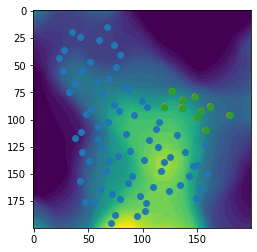

In [59]:
plt.imshow(map_prop[:,:,0])
plt.scatter(X,Y)
plt.scatter(X,Y,s=test_id*30)
plt.scatter(X[-10:],Y[-10:])

In [60]:
test_prod_64,train_prod_64,coefficients_64,patches_64=get_test_coef(window_size=64,min_test_well=5,NN=100)
cnn_64_pred=cnn_model(patches_64[:,:,:,:9]).numpy()*20
cnn_64_test_prod=cnn_64_pred.flatten()-train_prod_64
cnn_64_test_prod=cnn_64_test_prod*prod_scale+prod_bias

test_prod_32,train_prod_32,coefficients_32,patches_32=get_test_coef(window_size=32,min_test_well=1,NN=100)
cnn_32_pred=cnn_model32(patches_32[:,:,:,:9]).numpy()*4
cnn_32_test_prod=cnn_32_pred.flatten()-train_prod_32
cnn_32_test_prod=cnn_32_test_prod*prod_scale+prod_bias

test_prod_16,train_prod_16,coefficients_16,patches_16=get_test_coef(window_size=16,min_test_well=1,NN=100)
cnn_16_pred=cnn_model16(patches_16[:,:,:,:9]).numpy()*2
cnn_16_test_prod=cnn_16_pred.flatten()-train_prod_16
cnn_16_test_prod=cnn_16_test_prod*prod_scale+prod_bias

In [61]:
test_prod_64,train_prod_64,coefficients_64,patches_64=get_test_coef(window_size=64,min_test_well=5,NN=100)
cnn_64_pred=cnn_model(patches_64[:,:,:,:9]).numpy()*20
cnn_64_test_prod=cnn_64_pred.flatten()-train_prod_64
cnn_64_test_prod=cnn_64_test_prod*prod_scale+prod_bias

test_prod_32,train_prod_32,coefficients_32,patches_32=get_test_coef(window_size=32,min_test_well=1,NN=100)
cnn_32_pred=cnn_model32(patches_32[:,:,:,:9]).numpy()*4
cnn_32_test_prod=cnn_32_pred.flatten()-train_prod_32
cnn_32_test_prod=cnn_32_test_prod*prod_scale+prod_bias

test_prod_16,train_prod_16,coefficients_16,patches_16=get_test_coef(window_size=16,min_test_well=1,NN=100)
cnn_16_pred=cnn_model16(patches_16[:,:,:,:9]).numpy()*2
cnn_16_test_prod=cnn_16_pred.flatten()-train_prod_16
cnn_16_test_prod=cnn_16_test_prod*prod_scale+prod_bias

In [62]:
multipliers=1/np.array(noise_std)

bb=np.concatenate([multipliers[0]*cnn_64_test_prod,multipliers[1]*cnn_32_test_prod,
                   multipliers[2]*cnn_16_test_prod,multipliers[3]*predictions])

A=np.concatenate([multipliers[0]*coefficients_64,multipliers[1]*coefficients_32,
                  multipliers[2]*coefficients_16,multipliers[3]*np.eye(int(np.sum(test_id)))],axis=0)
solution,resid,rank,s=np.linalg.lstsq(A,bb)

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [63]:
final_result=np.sqrt(50000)*np.random.normal(0,1,(100,10))+solution

In [64]:
np.savetxt("final_result.csv", np.concatenate([final_result],axis=0), delimiter=",")

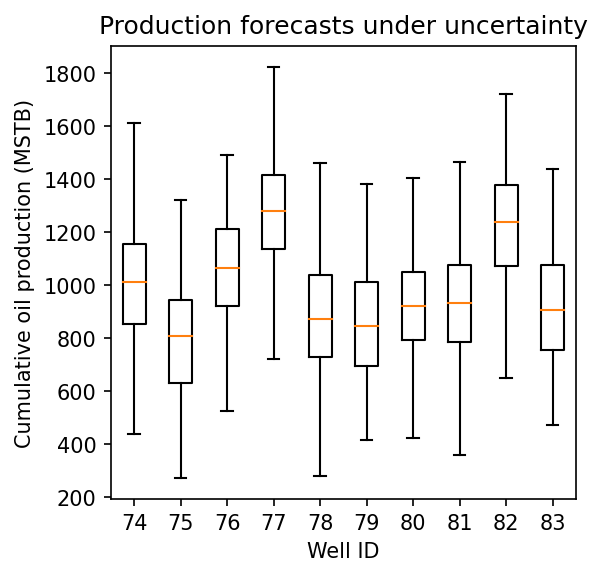

In [65]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi =150)
# plot violin plot
axs.boxplot(final_result, showfliers=False)
axs.set_title('Production forecasts under uncertainty')
plt.setp(axs, xticks=[y + 1 for y in range(10)],
         xticklabels=[y + 74 for y in range(10)])
plt.xlabel("Well ID")
plt.ylabel('Cumulative oil production (MSTB)')
plt.show()


In [74]:
import random
random.choice(np.arange(10))
final_result.shape

(100, 10)

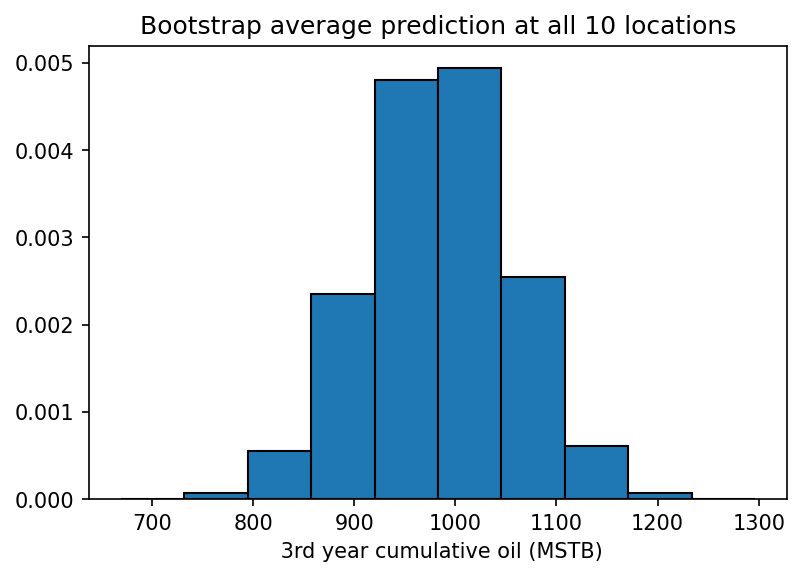

Historical mean production at the field: 940.976 MSTB
Mean production forecast at the proposed wells: 984.868 MSTB , 4.66 % smaller than the historical average 
P10 forecast at the proposed wells: 891.637 MSTB, 5.24 % smaller than the historical average
P90 forecast at the proposed wells: 1077.644 MSTB, 14.52 % larger than the historical average


In [90]:
## bootstrap
bs_means = np.zeros(100000)
for i in range(100000):
    mean_i = np.mean(np.array([final_result[random.choice(np.arange(100)), i] for i in range(10)]))
    bs_means[i] = mean_i
plt.figure(dpi=150)
plt.title("Bootstrap average prediction at all 10 locations")
plt.hist(bs_means, density =True, edgecolor ='k')
plt.xlabel(" 3rd year cumulative oil (MSTB)")
plt.show()
historical_avg = df_merged['Cumoil3'].mean()

# perms = set(permutations(a))
mean_pred , p10, p90 = bs_means.mean(), np.percentile(bs_means, 10), np.percentile(bs_means, 90)
mean_percent = (-historical_avg + mean_pred) / historical_avg * 100
p10_percent = (historical_avg - p10) / historical_avg * 100
p90_percent = (-historical_avg + p90) / historical_avg * 100

print("Historical mean production at the field: {0:.3f} MSTB".format(historical_avg))
print("Mean production forecast at the proposed wells: {0:.3f} MSTB , {1:.2f} % smaller than the historical average ".format(mean_pred, mean_percent))

print("P10 forecast at the proposed wells: {0:.3f} MSTB, {1:.2f} % smaller than the historical average".format(p10, p10_percent))
print("P90 forecast at the proposed wells: {0:.3f} MSTB, {1:.2f} % larger than the historical average".format(p90, p90_percent))

### Recommendations

Based on our analysis and uncertainty study, Team Anticline endorses the development plan at the proposed wells. At worst, P10 Production forecasts are only 5.14 % smaller than the historical average. On the other hand our P90 estimate is 14.5 % larger than the historical average. Considering the fact that the new wells are not well positioned in terms of geological qualities compared to other regions, these predictions are very encouraging. 